# Uso de Técnicas de Aprendizado de Máquina para a Predição do Tempo de Graduação dos Discentes de Engenharia da Computação na Região Sul do Brasil

In [2]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import glob
import os

In [3]:
#Importação da base de dados

caminho_diretorio = r"Microdados_Enade_2023\DADOS"

# Buscar todos os arquivos .csv com padrão especificado
arquivos = glob.glob(os.path.join(caminho_diretorio, "microdados2023_arq*.csv"))

dfs = []
colunas_existentes = set()

for arquivo in arquivos:
    df = pd.read_csv(arquivo, delimiter=";", encoding="latin1", low_memory=False)
    
    # Filtra apenas colunas ainda não adicionadas
    colunas_novas = [col for col in df.columns if col not in colunas_existentes]
    
    if colunas_novas:
        dfs.append(df[colunas_novas])
        colunas_existentes.update(colunas_novas)

# Concatena os dados horizontalmente (colunas diferentes, mesmas linhas)
df = pd.concat(dfs, axis=1)

# Filtrar por curso e região
df = df[
    (df["CO_GRUPO"] == 6411) & 
    (df["CO_REGIAO_CURSO"] == 4)
]

# Salva resultado
# df_final.to_csv(os.path.join(caminho_diretorio, "base_final.csv"), index=False, sep=";")

## Análise exploratória e pré-processamento
### Amostra inicial

In [5]:
df.head()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,TP_SEXO,NU_IDADE,QE_I01,QE_I02,QE_I03
4360,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4361,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4362,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4363,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN
4364,2023,872,10,8,10028,6411,1,4106902,41,4,...,NaN,NaN,NaN,NaN,NaN,F,21,NaN,NaN,NaN


### Informações da base de dados

In [7]:
def info_completo(df):
    tabela = pd.DataFrame({
        'Tipo': df.dtypes,
        'Não Nulos': df.notnull().sum(),
        'Nulos': df.isnull().sum(),
        'Únicos': df.nunique()
    })
    display(tabela)
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
NU_ANO,int64,887,0,1
CO_CURSO,int64,887,0,33
CO_IES,int64,887,0,26
CO_CATEGAD,int64,887,0,4
CO_ORGACAD,int64,887,0,4
...,...,...,...,...
TP_SEXO,object,887,0,2
NU_IDADE,int64,887,0,16
QE_I01,object,865,22,3
QE_I02,object,865,22,4


### Resumo estatístico das variáveis

In [9]:
df.describe()

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,NU_IDADE
count,887.0,8.870000e+02,887.000000,887.000000,887.000000,887.0,887.000000,8.870000e+02,887.000000,887.0,...,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,887.000000
mean,2023.0,8.892754e+05,1312.740699,3.216460,10025.001127,6411.0,0.684329,4.158298e+06,41.492672,4.0,...,5.350289,5.408092,5.262428,5.357225,5.611561,5.627746,5.619653,5.166474,5.42659,27.862458
std,0.0,5.532997e+05,1667.231131,2.391303,3.822087,0.0,0.465045,7.715309e+04,0.770288,0.0,...,1.204189,1.121622,1.286247,1.201184,0.917603,0.984918,0.896150,1.510774,1.23584,4.741777
min,2023.0,8.720000e+02,10.000000,1.000000,10020.000000,6411.0,0.000000,4.101408e+06,41.000000,4.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,21.000000
25%,2023.0,1.156160e+05,588.000000,1.000000,10020.000000,6411.0,0.000000,4.106902e+06,41.000000,4.0,...,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.00000,25.000000
50%,2023.0,1.155374e+06,588.000000,4.000000,10028.000000,6411.0,1.000000,4.106902e+06,41.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,26.000000
75%,2023.0,1.315345e+06,1491.000000,4.000000,10028.000000,6411.0,1.000000,4.204202e+06,42.000000,4.0,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,30.000000
max,2023.0,1.537513e+06,14951.000000,8.000000,10028.000000,6411.0,1.000000,4.321808e+06,43.000000,4.0,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,50.000000


In [10]:
# Apagar registro de formandos que faltaram ao dia de aplicação do ENADE.

df = df[df["TP_PRES"] == 555]
df.shape

(865, 125)

In [11]:
# Criação de váriaveis, incluindo a variável alvo (ATRASOU_FORM) 
df["ATRASOU_FORM"] = 2023 - df["ANO_IN_GRAD"]
df["ATRASOU_FORM"] = pd.cut(df["ATRASOU_FORM"], bins=[-float('inf'), 4, float('inf')], labels=[0, 1]).astype(int)

df["FIM_UM_ANO_ANTES"] = ((df["ANO_FIM_EM"] == df["ANO_IN_GRAD"] - 1)).astype(int)


In [12]:
# Apagando colunas consideradas desnecessárias ou que geram overfitting

df = df.drop(columns=[
    'NU_ANO', 'CO_GRUPO', 'CO_MUNIC_CURSO', 'CO_REGIAO_CURSO',
    'NU_ITEM_OFG', 'NU_ITEM_OFG_Z', 'NU_ITEM_OFG_X', 'NU_ITEM_OFG_N',
    'NU_ITEM_OCE', 'NU_ITEM_OCE_Z', 'NU_ITEM_OCE_X', 'NU_ITEM_OCE_N',
    'DS_VT_GAB_OFG_FIN', 'DS_VT_GAB_OCE_FIN', 'DS_VT_ESC_OFG', 'DS_VT_ACE_OFG',
    'DS_VT_ESC_OCE', 'DS_VT_ACE_OCE', 'TP_PRES', 'TP_PR_GER', 'TP_PR_OB_FG',
    'TP_PR_DI_FG', 'TP_PR_OB_CE', 'TP_PR_DI_CE', 'TP_SFG_D1', 'TP_SCE_D1', 
    'QE_I03', 'QE_I12', 'QE_I13', 'QE_I14', 'QE_I15', 'QE_I16', 'QE_I18', 'QE_I19', 'QE_I24', 
    "ANO_IN_GRAD", "ANO_FIM_EM"
])

In [13]:
# Redução de cardinalidade das variáveis do questionário

# Função para simplificar as respostas
def simplificar_opinioes(valor):
    if valor in [1, 2, 3]:
        return 1 #Discordo
    elif valor in [4, 5, 6]:
        return 2 #Concordo
    elif valor in [7, 8]:
        return 3 #Não sei
    else:
        return np.nan  # Para lidar com valores inesperados ou ausentes

# Lista das colunas de interesse (QE_I27 a QE_I68)
colunas_opinioes = [f'QE_I{i}' for i in range(27, 69) if f'QE_I{i}' in df.columns]

# Aplicar a transformação
for col in colunas_opinioes:
    df[col] = df[col].apply(simplificar_opinioes)


In [14]:
# 0- Casado / 1- Não casado
df['QE_I01'] = df['QE_I01'].apply(lambda x: 0 if x in ["B"] else 1)

# 0- Branco e amarelo / 1- Preto, pardo e indígena / 2- Outros
df['QE_I02'] = df['QE_I02'].apply(lambda x: 0 if x in ["A", "C"] else 1 if x in ["B", "D", "E"] else 2 if x in ["F"] else np.nan)

# 0- Até o fundamental completo / 1- Ensino médio / 2- Ensino superior e pós
df['QE_I04'] = df['QE_I04'].apply(lambda x: 0 if x in ["A", "B", "C"] else 1 if x in ["D"] else 2 if x in ["E", "F"] else np.nan)

df['QE_I05'] = df['QE_I05'].apply(lambda x: 0 if x in ["A", "B", "C"] else 1 if x in ["D"] else 2 if x in ["E", "F"] else np.nan)

# 0- Mora com pais ou parentes / 1- Outras moradias
df['QE_I06'] = df['QE_I06'].apply(lambda x: 0 if x in ["B"] else 1)

# 0- Até uma pessoa / 1- Duas / 2- Três / 3- Quatro ou mais
df['QE_I07'] = df['QE_I07'].apply(lambda x: 0 if x in ["A", "B"] else 1 if x in ["C"] else 2 if x in ["D"] else 3 if x in ["E", "F", "G"] else np.nan)

# 0- Até 3 salários mínimos / 1- Até 4,5 salários / 2- Acima de 4,5 salários
df['QE_I08'] = df['QE_I08'].apply(lambda x: 0 if x in ["A", "B"] else 1 if x in ["C"] else 2 if x in ["D", "E", "F", "G"] else np.nan)

# 0- Gastos são financiados / 1- Tem renda, mas recebe ajuda / 2- Tem renda, mas não precisa de ajuda / 3- Contribui para o sustento da família
df['QE_I09'] = df['QE_I09'].apply(lambda x: 0 if x in ["A", "B"] else 1 if x in ["C"] else 2 if x in ["D"] else 3 if x in ["E", "F"] else np.nan)

# 0- Não trabalha / 1- Trabalha até 39 horas semanais / 2- Trabalha 40 horas ou mais / 3- Outros
df['QE_I10'] = df['QE_I10'].apply(lambda x: 0 if x in ["A"] else 1 if x in ["B", "C", "D"] else 2 if x in ["E"] else 3 if x in ["F"] else np.nan)

# 0- Nenhuma / 1- Recebe
df['QE_I11'] = df['QE_I11'].apply(lambda x: 0 if x in ["A", "B"] else 1)
df['QE_I11'] = df['QE_I11'].astype('Int64')

# 0- Total em escola pública / 1- Parcial ou total em particular ou fora do Brasil
df['QE_I17'] = df['QE_I17'].apply(lambda x: 0 if x in ["A"] else 1 if x in ["B", "C", "D", "E", "F"] else np.nan)

# 0- Apoio dos pais / 1- Outros
df['QE_I20'] = df['QE_I20'].apply(lambda x: 0 if x in ["C"] else 1)

# 0- Sim / 1- Não
df['QE_I21'] = df['QE_I21'].apply(lambda x: 0 if x in ["A"] else 1)

# 0- Até dois livros / 1- Mais de dois
df['QE_I22'] = df['QE_I22'].apply(lambda x: 0 if x in ["A", "B"] else 1 if x in ["C", "D", "E"] else np.nan)

# 0- Até três horas / 1- Quatro horas ou mais
df['QE_I23'] = df['QE_I23'].apply(lambda x: 0 if x in ["A", "B"] else 1)

# 0- Valorização profissional / 1- Vocação / 2- Outro
df['QE_I25'] = df['QE_I25'].apply(lambda x: 0 if x in ["C"] else 1 if x in ["E"] else 2)

# 0- Facilidades / 1- Qualidade/reputação
df['QE_I26'] = df['QE_I26'].apply(lambda x: 0 if x in ["A", "B", "C", "D", "E", "G", "H", "I"] else 1 if x in ["F"] else np.nan)

# 0- Feminino / 1- M
df['TP_SEXO'] = df['TP_SEXO'].apply(lambda x: 0 if x in ["F"] else 1)


In [15]:
# Lista de sufixos a serem removidos
sufixos_para_remover = list(range(27, 40)) + list(range(42, 44)) + [45] + list(range(47, 52)) + list(range(54, 62)) + list(range(63, 67)) + [68]
colunas_para_remover = [f'QE_I{sufixo}' for sufixo in sufixos_para_remover]

df = df.drop(columns=[col for col in colunas_para_remover if col in df.columns])


In [16]:
# # Codificação de variáveis categóricas
# from sklearn.preprocessing import LabelEncoder


# colunas_categoricas = ['CO_CURSO', 'CO_IES', 'CO_CATEGAD', 'CO_ORGACAD', 'CO_MODALIDADE', 'CO_UF_CURSO', 'TP_SEXO']

# # Aplicar LabelEncoder em cada uma
# le = LabelEncoder()

# for col in colunas_categoricas:
#     if col in df.columns:
#         df[col] = le.fit_transform(df[col].astype(str))


In [17]:
# Encoding das variáveis ordinais

# CO_RS_I1 a CO_RS_I9
mapeamento_ordem = {
    'A': 0,  
    'B': 1,  
    'C': 2,  
    'D': 3,  
    'E': 4,  
    '*': 5,  
    '.': 5,  
    '' : 5    
}

colunas_rs = [f'CO_RS_I{i}' for i in range(1, 10)]

# Aplicar o mapeamento em cada uma
for col in colunas_rs:
    if col in df.columns:
        df[col] = df[col].map(mapeamento_ordem)


### Descrição dos dados após tratamento prévio

In [19]:
df.describe()

,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_MODALIDADE,CO_UF_CURSO,QE_I04,QE_I05,QE_I06,QE_I07,...,QE_I52,QE_I53,QE_I62,QE_I67,TP_SEXO,NU_IDADE,QE_I01,QE_I02,ATRASOU_FORM,FIM_UM_ANO_ANTES
count,8.650000e+02,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.00000,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,865.000000,865.000000,865.000000
mean,9.118706e+05,1345.873988,3.094798,10024.924855,0.676301,41.505202,0.804624,1.338728,0.390751,1.363006,...,1.89711,1.872832,1.921387,1.915607,0.478613,28.036994,0.92948,0.440462,0.470520,0.336416
std,5.415974e+05,1675.149213,2.294878,3.839988,0.468158,0.775960,0.569256,0.573077,0.488201,0.833345,...,0.66653,0.728084,0.354623,0.439433,0.499831,4.671973,0.25617,0.496730,0.499419,0.472757
min,6.482200e+04,13.000000,1.000000,10020.000000,0.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,1.000000,1.000000,1.000000,0.000000,23.000000,0.00000,0.000000,0.000000,0.000000
25%,1.156160e+05,588.000000,1.000000,10020.000000,0.000000,41.000000,0.000000,1.000000,0.000000,1.000000,...,1.00000,1.000000,2.000000,2.000000,0.000000,25.000000,1.00000,0.000000,0.000000,0.000000
50%,1.155374e+06,588.000000,4.000000,10028.000000,1.000000,41.000000,1.000000,1.000000,0.000000,1.000000,...,2.00000,2.000000,2.000000,2.000000,0.000000,26.000000,1.00000,0.000000,0.000000,0.000000
75%,1.315345e+06,1491.000000,4.000000,10028.000000,1.000000,42.000000,1.000000,2.000000,1.000000,2.000000,...,2.00000,2.000000,2.000000,2.000000,1.000000,30.000000,1.00000,1.000000,1.000000,1.000000
max,1.537513e+06,14951.000000,8.000000,10028.000000,1.000000,43.000000,2.000000,2.000000,1.000000,3.000000,...,3.00000,3.000000,3.000000,3.000000,1.000000,50.000000,1.00000,1.000000,1.000000,1.000000


### Informações do dataset final

In [21]:
info_completo(df)

,Tipo,Não Nulos,Nulos,Únicos
CO_CURSO,int64,865,0,32
CO_IES,int64,865,0,25
CO_CATEGAD,int64,865,0,4
CO_ORGACAD,int64,865,0,4
CO_MODALIDADE,int64,865,0,2
CO_UF_CURSO,int64,865,0,3
QE_I04,int64,865,0,3
QE_I05,int64,865,0,3
QE_I06,int64,865,0,2
QE_I07,int64,865,0,4


In [22]:
df.shape

(865, 56)

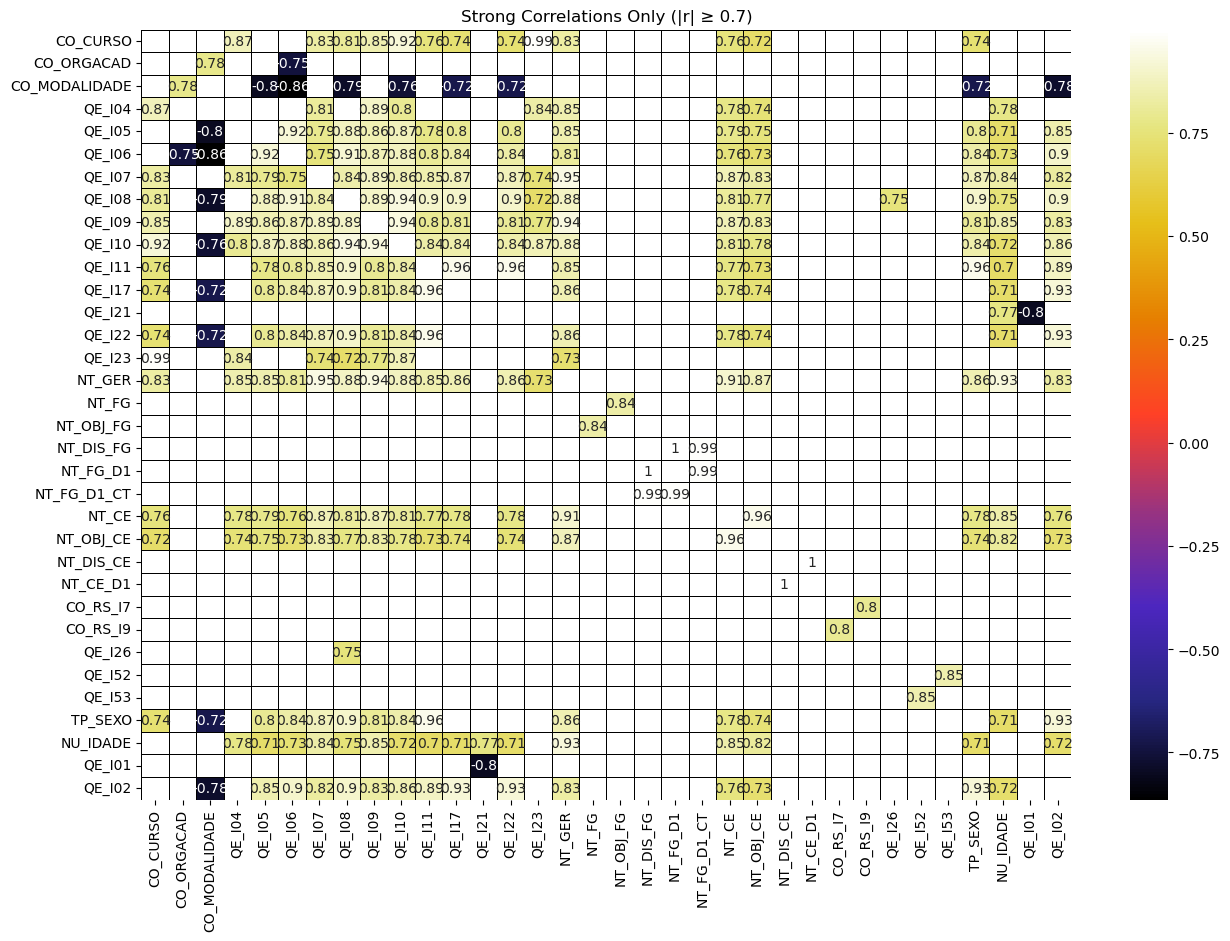

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas as colunas numéricas
numeric_features = df.select_dtypes(include=['int64', 'float64', 'int32']).columns

# Calcula a matriz de correlação
corr_matrix = df[numeric_features].corr()

# Aplica máscara para manter apenas correlações fortes
threshold = 0.7
strong_corr = corr_matrix[(np.abs(corr_matrix) >= threshold) & (corr_matrix != 1.0)]

# Remove colunas/linhas com todos os valores NaN (sem correlação forte)
strong_corr = strong_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Exibe o heatmap com linhas separando as células se houver correlações fortes
if not strong_corr.empty:
    plt.figure(figsize=(15, 10))
    sns.heatmap(strong_corr, cmap="CMRmap", annot=True, linewidths=0.5, linecolor='black')  # Linha separando células
    plt.title("Strong Correlations Only (|r| ≥ 0.7)")
    plt.show()
else:
    print("Não foram encontradas correlações fortes (|r| ≥ 0.7).")


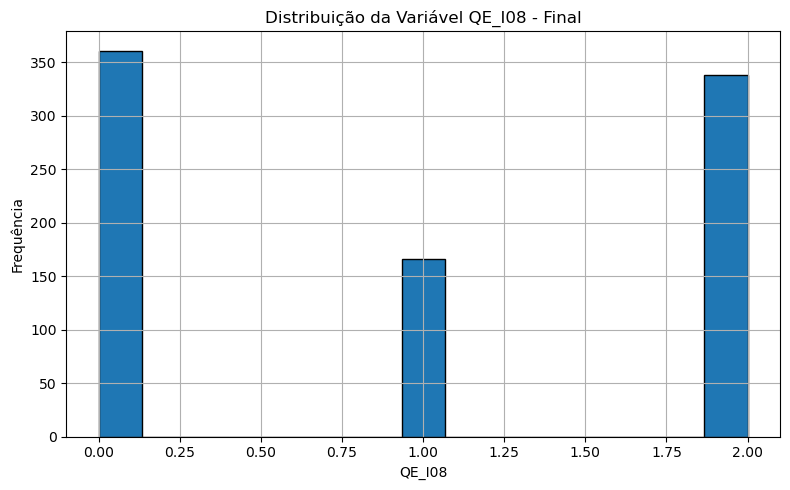

In [24]:
import matplotlib.pyplot as plt

# Gerar histograma apenas para a coluna QR_I08
plt.figure(figsize=(8, 5))
plt.hist(df['QE_I08'].dropna(), bins=15, edgecolor='black')
plt.title("Distribuição da Variável QE_I08 - Final")
plt.xlabel("QE_I08")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()


### Gerar histograma para todas as colunas numéricas

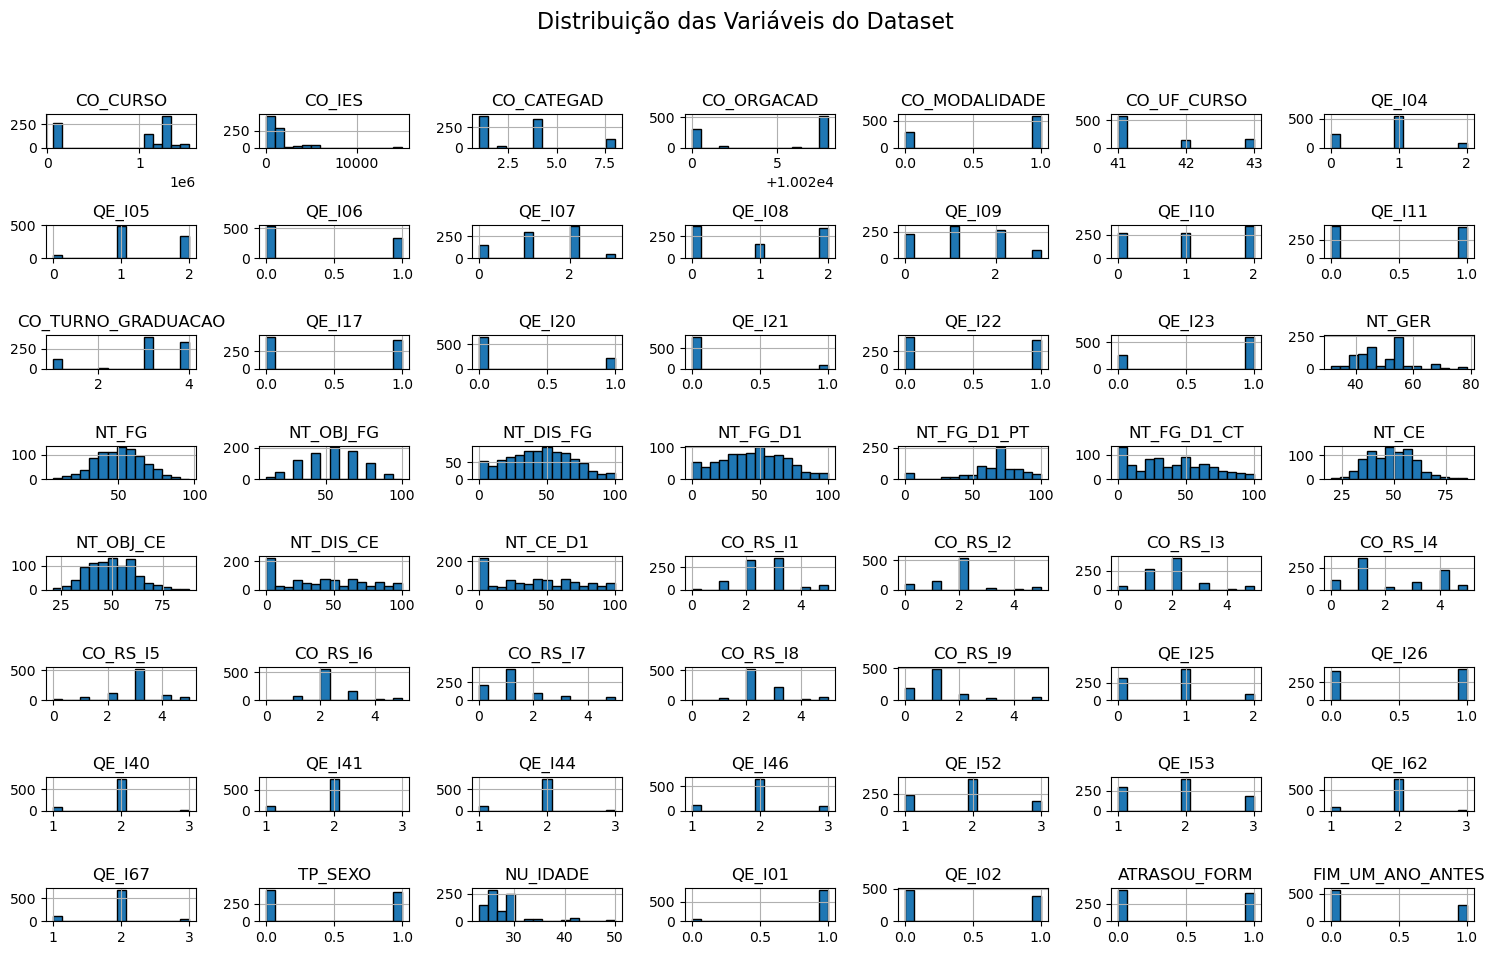

In [26]:
import matplotlib.pyplot as plt

# Gerar histograma para todas as colunas numéricas
fig = df.hist(figsize=(15, 10), bins=15, edgecolor='black')

# Adicionar um título geral ao conjunto de subgráficos
plt.suptitle("Distribuição das Variáveis do Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste para o título não sobrepor os gráficos
plt.show()


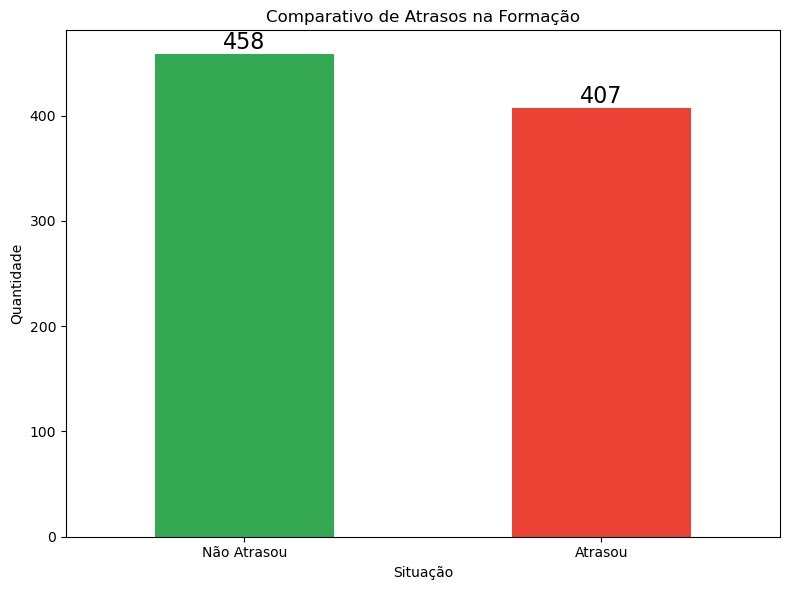

In [66]:
# Contando a quantidade de cada valor na coluna 'ATRASOU_FORM'
contagem_atrasos = df['ATRASOU_FORM'].value_counts()

# Mapeando os valores para os rótulos desejados
rotulos = {0: 'Não Atrasou', 1: 'Atrasou'}
contagem_atrasos.index = contagem_atrasos.index.map(rotulos)

# Criando o gráfico de barras
plt.figure(figsize=(8, 6))
bars = contagem_atrasos.plot(kind='bar', color=['#34A853', '#EA4335'])

# Adicionando título e rótulos aos eixos
plt.title('Comparativo de Atrasos na Formação')
plt.xlabel('Situação')
plt.ylabel('Quantidade')
plt.xticks(rotation=0) # Mantém os rótulos do eixo x na horizontal

# Adicionando os valores no topo de cada barra
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=16) # centraliza o texto

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### Distribuição das Variáveis Categóricas (object) - Após tratamento não existem mais

In [28]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Selecionar apenas as colunas categóricas (object)
# categorical_cols = df.select_dtypes(include='object').columns

# # Definir o tamanho da grade
# n_cols = 3  # número de colunas de gráficos por linha
# n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
# axes = axes.flatten()

# for i, col in enumerate(categorical_cols):
#     sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
#     axes[i].set_title(f'Distribuição de {col}')
#     axes[i].tick_params(axis='x', rotation=45)

# # Remover subplots vazios
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# # Título geral e layout
# plt.suptitle("Distribuição das Variáveis Categóricas (object)", fontsize=20)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


## Pré-processamento

In [30]:
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from sklearn.metrics import classification_report
# from catboost import CatBoostClassifier

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Identificar variáveis categóricas (CatBoost aceita índices das colunas)
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
# categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# # Converter colunas categóricas para string
# for col in categorical_column_names:
#     X[col] = X[col].astype(str)

In [31]:
# #Instalando o CatBoost
# import sys
# !{sys.executable} -m pip install catboost


## CatBoost 

In [33]:
# # Encontrar o melhor modelo do CatBoost

# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from sklearn.metrics import classification_report
# from catboost import CatBoostClassifier

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Identificar variáveis categóricas (CatBoost aceita índices das colunas)
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
# categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# # Converter colunas categóricas para string
# for col in categorical_column_names:
#     X[col] = X[col].astype(str)

# # Modelo base
# model = CatBoostClassifier(
#     eval_metric='Accuracy',
#     verbose=0, 
#     cat_features = categorical_features_idx,
#     random_state = 42
# )

# # Espaço de busca para os hiperparâmetros
# param_grid = {
#     'iterations': [50, 100, 200, 300, 500],
#     'depth': [4, 6, 8, 10],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# # Validação cruzada estratificada no conjunto de treino
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # GridSearchCV com validação cruzada apenas no treino
# grid = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=cv,
#     n_jobs=-1
# )

# # Ajuste no conjunto de treino
# grid.fit(X, y)


# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Média da acurácia nos 5 folds:", grid.best_score_)

Melhores parâmetros encontrados: {'depth': 8, 'iterations': 50, 'learning_rate': 0.001}
Média da acurácia nos 5 folds: 0.8843930635838151


Acurácia sem arredondamento: 0.884393063583815


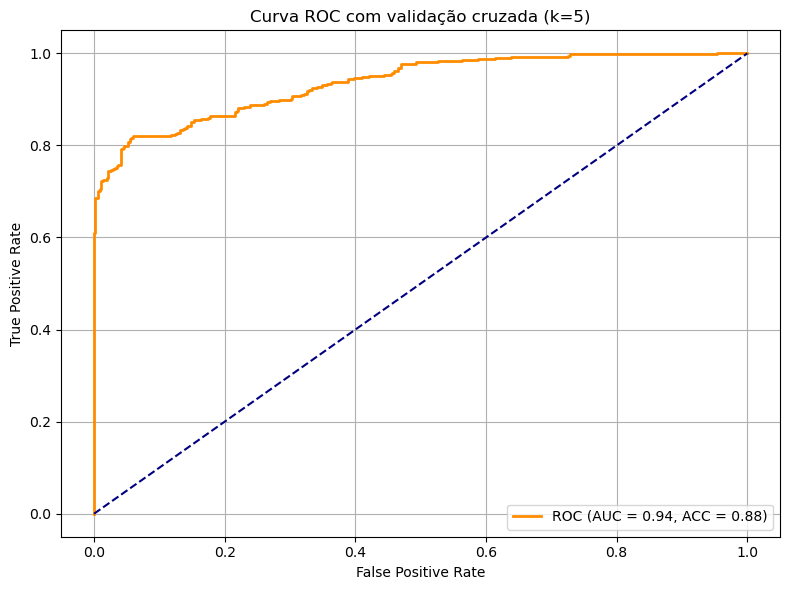

In [68]:
# Melhor modelo do CatBoost sem redução de dimensionalidade

from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Identificar variáveis categóricas (CatBoost aceita índices das colunas)
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# Converter colunas categóricas para string
for col in categorical_column_names:
    X[col] = X[col].astype(str)

# Parâmetros ideais do modelo
params = {
    'iterations': 50,
    'depth': 8,
    'learning_rate': 0.001,
    'eval_metric': 'Accuracy',
    'verbose': 0,
    'cat_features': categorical_features_idx,
    'random_state': 42
}

# Modelo
model = CatBoostClassifier(**params)

# Estratégia de validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
# Usamos method='predict_proba' para obter as probabilidades da classe positiva
y_proba_all = cross_val_predict(
    model, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

# Também obtemos as predições (classe final)
y_pred_all = cross_val_predict(
    model, X, y, cv=cv, method='predict', n_jobs=-1
)

# Métricas
fpr, tpr, _ = roc_curve(y, y_proba_all)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred_all)

print("Acurácia sem arredondamento:", acc)


# Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


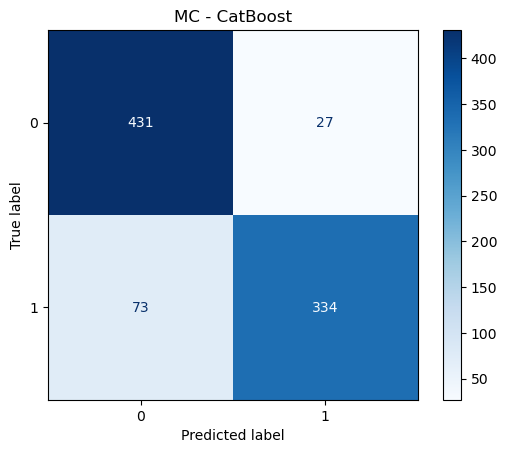

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcula a matriz de confusão
cm = confusion_matrix(y, y_pred_all)

# Plota a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('MC - CatBoost')
plt.show()


## CatBoost com PCA

In [37]:
# # Escolher modelo do CatBoost com PCA
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import classification_report

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']


# # Colunas categóricas e numéricas
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Pré-processamento
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
#         ('num', 'passthrough', nao_categoricas)
#     ]
# )

# # Pipeline completo com pré-processamento, escalonamento, PCA e classificador
# pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessor),
#     ('scaling', StandardScaler()),
#     ('pca', PCA()),
#     ('clf', CatBoostClassifier(random_state=42, verbose=0))
# ])

# # Espaço de busca de hiperparâmetros (incluindo n_components do PCA e parâmetros do classificador)
# param_grid = {
#     'pca__n_components': [0.95, 0.99],  # Ajuste conforme número de features
#     'clf__n_estimators': [50, 100, 200, 300, 500],
#     'clf__depth': [4, 6, 8, 10],
#     'clf__learning_rate': [0.1, 0.01, 0.001]
# }


# # Validação cruzada estratificada com 5 folds
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # GridSearch com validação cruzada
# grid = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1
# )
# # Ajuste
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Melhor acurácia média nos folds:", grid.best_score_)


Melhores parâmetros encontrados: {'clf__depth': 8, 'clf__learning_rate': 0.1, 'clf__n_estimators': 500, 'pca__n_components': 0.99}
Melhor acurácia média nos folds: 0.8693641618497109


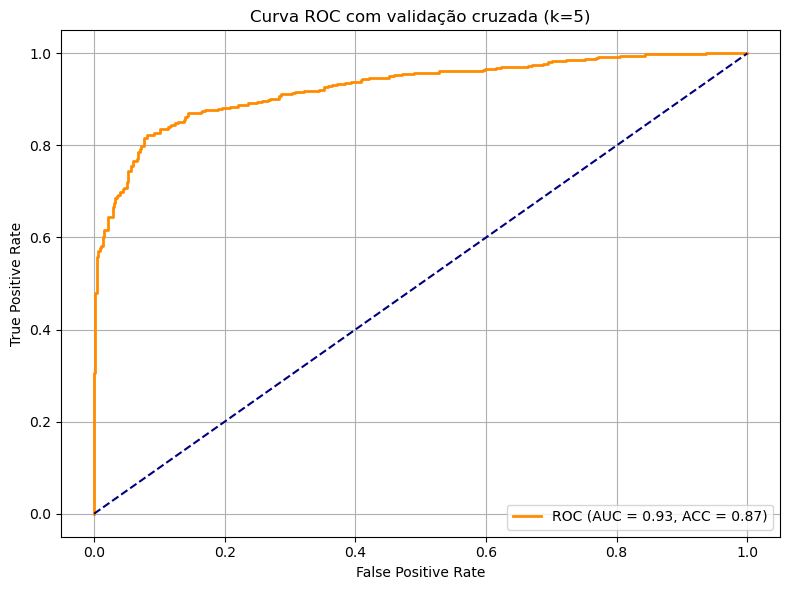

In [72]:
# Melhor modelo do CatBoost com PCA

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Colunas categóricas e numéricas
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
        ('num', 'passthrough', nao_categoricas)
    ]
)

# Pipeline com os melhores parâmetros
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
    ('clf', CatBoostClassifier(
        n_estimators=300,
        depth=8,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    ))
])

# Estratégia de validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict', n_jobs=-1)

# Métricas
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred)

# Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


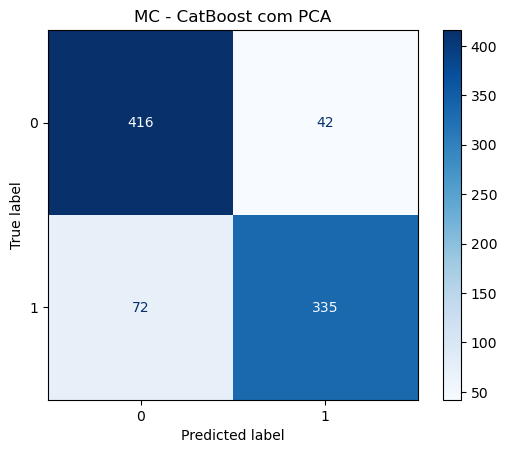

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcula a matriz de confusão
cm = confusion_matrix(y, y_pred)

# Exibe a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('MC - CatBoost com PCA')
plt.show()


## CatBoost com KBest

In [41]:
# # Escolher melhor modelo CatBoost com K-Best
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
# from sklearn.feature_selection import SelectKBest, chi2
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import classification_report

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Colunas categóricas e numéricas
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Pré-processamento
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
#         ('num', MinMaxScaler(), nao_categoricas)
#     ]
# )

# # Pipeline com SelectKBest no lugar do PCA
# pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessor),
#     ('selectkbest', SelectKBest(score_func=chi2)),
#     ('clf', CatBoostClassifier(random_state=42, verbose=0))
# ])

# # Espaço de busca de hiperparâmetros (incluindo k do SelectKBest)
# param_grid = {
#     'selectkbest__k': [10, 20, 30, 40, 'all'],
#     'clf__n_estimators': [50, 100, 200, 300, 500],
#     'clf__depth': [4, 6, 8, 10],
#     'clf__learning_rate': [0.1, 0.01, 0.001]
# }

# # Validação cruzada estratificada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # GridSearch com validação cruzada
# grid = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Ajuste
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Melhor acurácia média nos folds:", grid.best_score_)


Melhores parâmetros encontrados: {'clf__depth': 10, 'clf__learning_rate': 0.1, 'clf__n_estimators': 100, 'selectkbest__k': 10}
Melhor acurácia média nos folds: 0.8901734104046243


Acurácias em cada fold: [0.86127168 0.88439306 0.92485549 0.88439306 0.89595376]
Acurácia média nos folds: 0.8901734104046243
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       458
           1       0.92      0.84      0.88       407

    accuracy                           0.89       865
   macro avg       0.89      0.89      0.89       865
weighted avg       0.89      0.89      0.89       865

Acurácia média: 0.8901734104046243
AUC: 0.9398758623649454


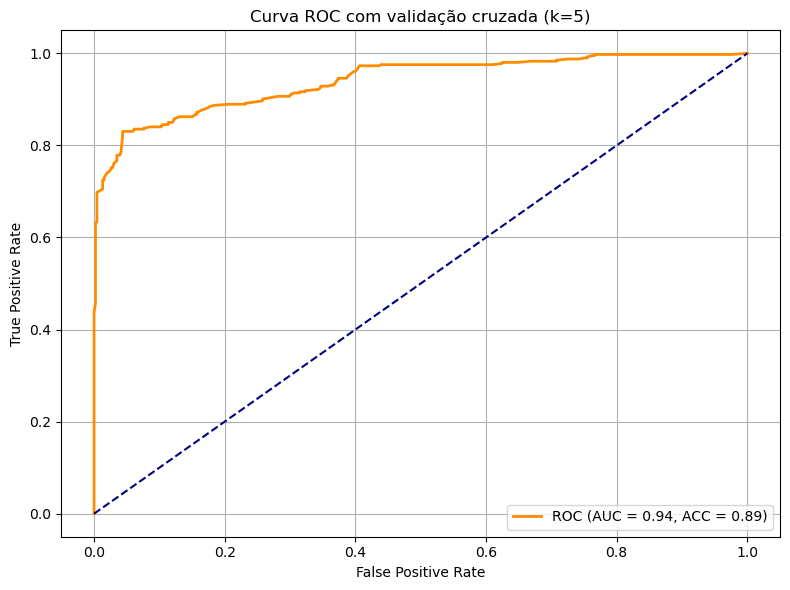

In [76]:
# Melhor modelo do CatBoost com Kbest

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Colunas categóricas e numéricas
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
        ('num', MinMaxScaler(), nao_categoricas)
    ]
)

# Pipeline final com os melhores parâmetros
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('selectkbest', SelectKBest(score_func=chi2, k=10)),
    ('clf', CatBoostClassifier(
        n_estimators=100,
        depth=10,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    ))
])

# Avaliação com validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Acurácia média por fold
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("Acurácias em cada fold:", scores)
print("Acurácia média nos folds:", scores.mean())

# Previsões com validação cruzada
y_prob = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba', n_jobs=-1)
y_pred = (y_prob[:, 1] >= 0.5).astype(int)

# Avaliação
acc = accuracy_score(y, y_pred)
fpr, tpr, _ = roc_curve(y, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

print(classification_report(y, y_pred))
print(f"Acurácia média: {acc}")
print(f"AUC: {roc_auc}")

# Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



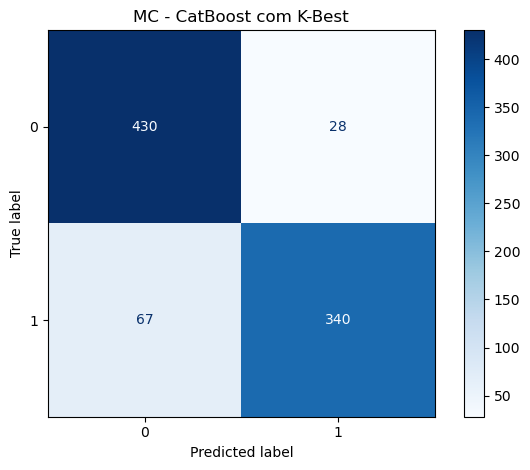

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão
cm = confusion_matrix(y, y_pred)

# Exibição da matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('MC - CatBoost com K-Best')
plt.grid(False)
plt.tight_layout()
plt.show()


## Ligth GBM 

In [45]:
# # #Instalando o LGBM
# !pip install lightgbm



In [46]:
# # Escolher melhor modelo do LGBM

# from lightgbm import LGBMClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']


# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
# categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# # Converter colunas categóricas para string
# for col in categorical_column_names:
#     X[col] = X[col].astype('category')


# model = LGBMClassifier(
#     objective='binary',
#     random_state=42,
#     verbose= -1
# )

# # Espaço de busca
# param_grid = {
#     'n_estimators': [50, 100, 200, 300, 500],
#     'max_depth': [4, 6, 8, 10],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# # Validação cruzada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com validação cruzada
# grid = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=cv,
#     n_jobs=-1
# )

# # Treinamento
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Média da acurácia nos 5 folds:", grid.best_score_)


Melhores parâmetros encontrados: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
Média da acurácia nos 5 folds: 0.8936416184971098


Acurácia:  0.8774566473988439
ROC AUC:  0.9398973209016878


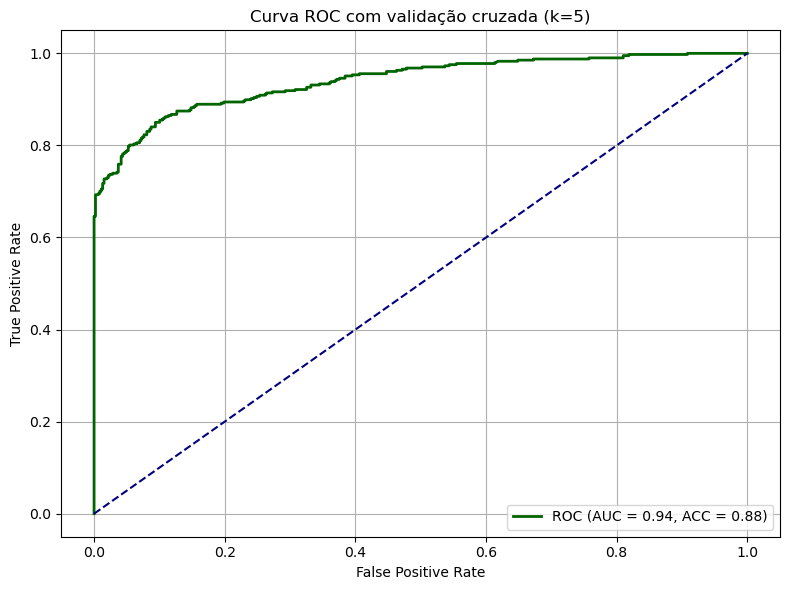

In [80]:
# Melhor modelo do LGBM sem redução de dimensionalidade

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Parâmetros ideais do modelo (substitua pelos encontrados)
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.01,
    'objective': 'binary',
    'random_state': 42,
    'verbose': -1
}

# Modelo
model = LGBMClassifier(**params)

# Estratégia de validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
y_proba_all = cross_val_predict(
    model, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_all = cross_val_predict(
    model, X, y, cv=cv, method='predict', n_jobs=-1
)

# Métricas
fpr, tpr, _ = roc_curve(y, y_proba_all)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred_all)

print('Acurácia: ', acc)
print('ROC AUC: ', roc_auc)

# Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


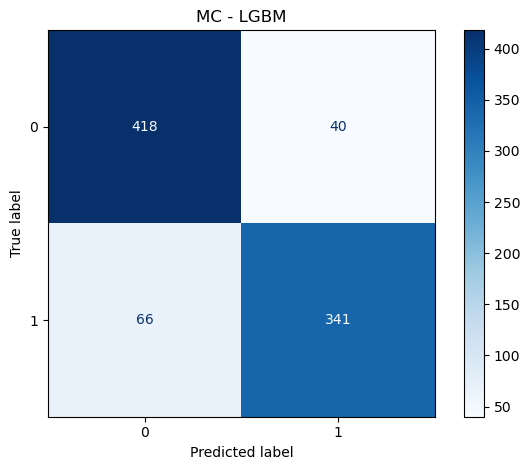

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão
cm = confusion_matrix(y, y_pred_all)

# Exibir matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('MC - LGBM')
plt.tight_layout()
plt.show()


## LGBM com K-Best

In [50]:
# # Escolher o melhor LGBM com K-Best

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import classification_report
# from lightgbm import LGBMClassifier

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Colunas categóricas e numéricas
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Pré-processamento: codificação ordinal e passthrough
# # Pré-processamento
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
#         ('num', MinMaxScaler(), nao_categoricas)
#     ]
# )

# # Pipeline com SelectKBest no lugar do PCA
# pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessor),
#     ('selectkbest', SelectKBest(score_func=chi2)),
#     ('clf', LGBMClassifier(random_state=42, verbose=-1))
# ])

# # Espaço de busca de hiperparâmetros
# param_grid = {
#     'selectkbest__k': [10, 20, 30, 40, 'all'],
#     'clf__n_estimators': [50, 100, 200, 300, 500],
#     'clf__max_depth': [4, 6, 8, 10],
#     'clf__learning_rate': [0.1, 0.01, 0.001]
# }

# # Validação cruzada estratificada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # GridSearch com validação cruzada
# grid = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=4
# )

# # Ajuste
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Melhor acurácia média nos folds:", grid.best_score_)


Melhores parâmetros encontrados: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'selectkbest__k': 10}
Melhor acurácia média nos folds: 0.8901734104046243


Acurácia média: 0.8901734104046243
AUC: 0.9364800489254638


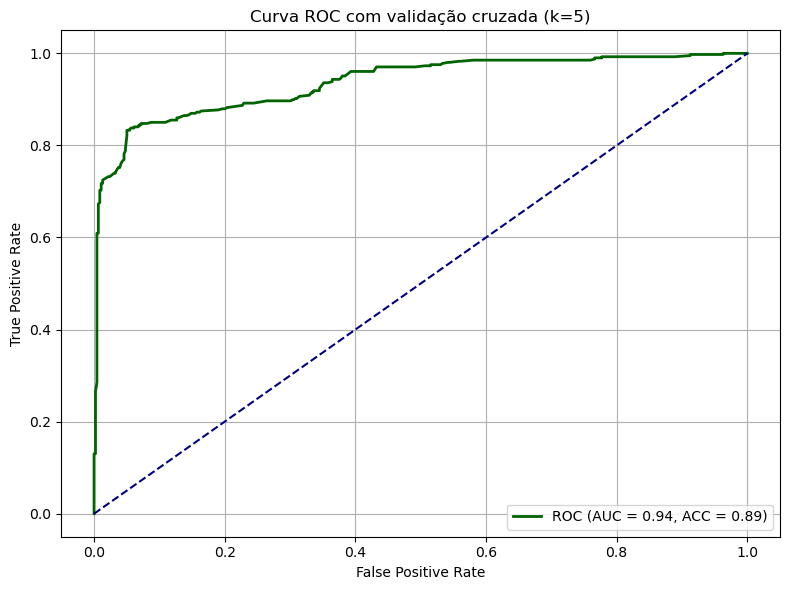

In [84]:
# Melhor modelo do LGBM com K-Best
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Colunas categóricas e numéricas
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
        ('num', MinMaxScaler(), nao_categoricas)
    ]
)

# Melhor modelo com hiperparâmetros já escolhidos
best_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('selectkbest', SelectKBest(score_func=chi2, k=10)),
    ('clf', LGBMClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    ))
])

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
y_proba_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict', n_jobs=-1
)

# Cálculo das métricas
fpr, tpr, _ = roc_curve(y, y_proba_all)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred_all)

print(f"Acurácia média: {acc}")
print(f"AUC: {roc_auc}")

# Plot da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

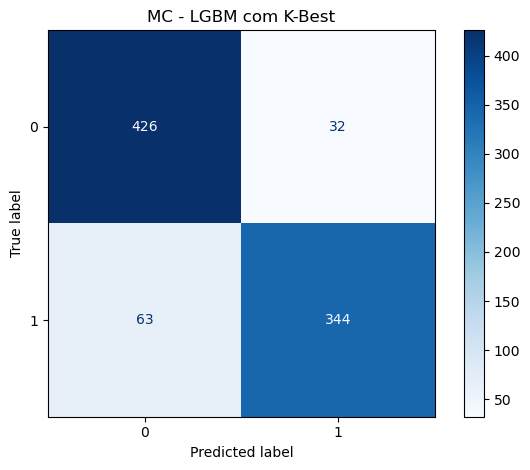

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão
cm = confusion_matrix(y, y_pred_all)

# Exibição
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('MC - LGBM com K-Best')
plt.grid(False)
plt.tight_layout()
plt.show()


## Random Forest

In [54]:
# # Escolher o melhor modelo de Random Forest
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Converter colunas categóricas para string (não é estritamente necessário para Random Forest, mas não prejudica)
# for col in categorical_column_names:
#     X[col] = X[col].astype('category')

# # Modelo Random Forest
# model = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1
# )

# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False]
# }


# # Validação cruzada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Grid Search com validação cruzada
# grid = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=cv,
#     n_jobs=-1
# )

# # Treinamento
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Média da acurácia nos 5 folds:", grid.best_score_)


Melhores parâmetros encontrados: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Média da acurácia nos 5 folds: 0.8913294797687861


Acurácia média: 0.8913294797687862
AUC: 0.9365524714869694


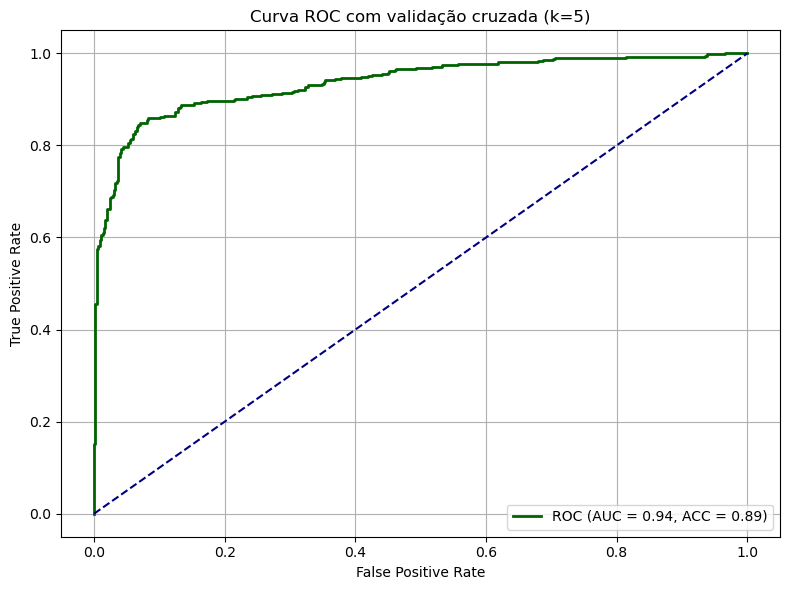

In [88]:
# Melhor modelo do Random Forest

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve, auc
import pandas as pd

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Converter colunas categóricas para string (opcional para Random Forest)
for col in categorical_column_names:
    X[col] = X[col].astype('category')

# Modelo Random Forest com os melhores hiperparâmetros (substitua pelos seus)
best_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
y_proba_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict', n_jobs=-1
)

# Cálculo das métricas
fpr, tpr, _ = roc_curve(y, y_proba_all)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred_all)

# Resultados
print(f"Acurácia média: {acc}")
print(f"AUC: {roc_auc}")

# Plot da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


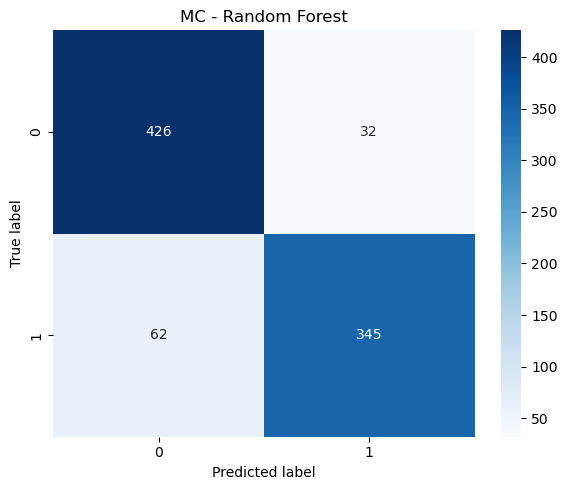

In [90]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Matriz de confusão
cm = confusion_matrix(y, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('MC - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# # Escolher o melhor modelo do Random Forest com K-Best

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Colunas categóricas e numéricas
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Pré-processamento
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
#         ('num', MinMaxScaler(), nao_categoricas)
#     ]
# )

# # Pipeline com SelectKBest e RandomForest
# pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessor),
#     ('selectkbest', SelectKBest(score_func=chi2)),
#     ('clf', RandomForestClassifier(random_state=42))
# ])


# param_grid = {
#     'selectkbest__k': [10, 20, 30, 40, 'all'],
#     'clf__n_estimators': [100, 200, 300, 500],
#     'clf__max_depth': [None, 10, 20, 30],
#     'clf__min_samples_split': [2, 5, 10],
#     'clf__min_samples_leaf': [1, 2, 4],
#     'clf__max_features': ['sqrt', 'log2', None],
#     'clf__bootstrap': [True, False]
# }


# # Validação cruzada estratificada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # GridSearch com validação cruzada
# grid = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=4
# )

# # Ajuste
# grid.fit(X, y)

# # Resultados
# print("Melhores parâmetros encontrados:", grid.best_params_)
# print("Melhor acurácia média nos folds:", grid.best_score_)




Acurácia média: 0.8959537572254336
AUC: 0.9401038593178332


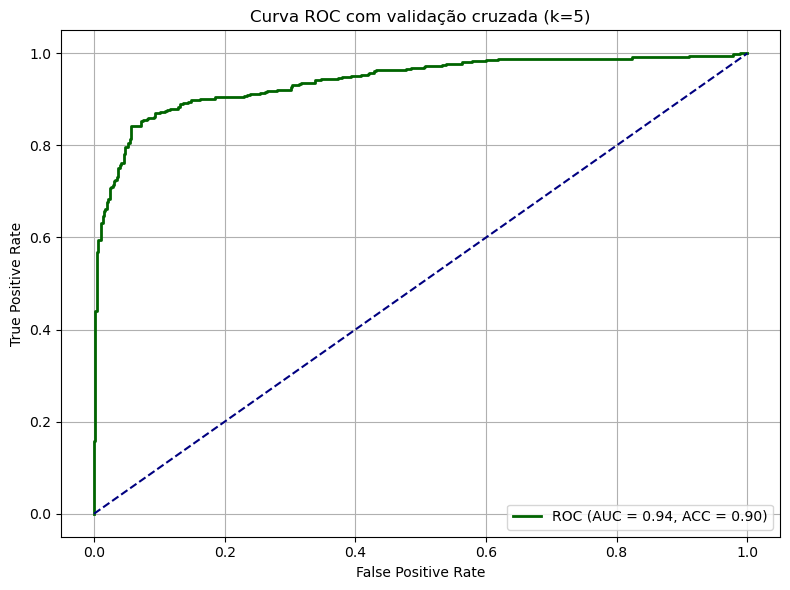

In [92]:
# Melhor modelo do Random Forest com K-Best

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Colunas categóricas e numéricas
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
        ('num', MinMaxScaler(), nao_categoricas)
    ]
)

# Modelo Random Forest com parâmetros fixos
best_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('selectkbest', SelectKBest(score_func=chi2, k=30)),
    ('clf', RandomForestClassifier(
        n_estimators = 300,
        max_depth = 10,
        min_samples_split = 10,
        min_samples_leaf = 4,
        max_features = 'sqrt',
        bootstrap = True,
        random_state=42 
    ))
])

# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Previsões com validação cruzada
y_proba_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_all = cross_val_predict(
    best_model, X, y, cv=cv, method='predict', n_jobs=-1
)

# Cálculo das métricas
fpr, tpr, _ = roc_curve(y, y_proba_all)
roc_auc = auc(fpr, tpr)
acc = accuracy_score(y, y_pred_all)

print(f"Acurácia média: {acc}")
print(f"AUC: {roc_auc}")

# Plot da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC (AUC = {roc_auc:.2f}, ACC = {acc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC com validação cruzada (k=5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

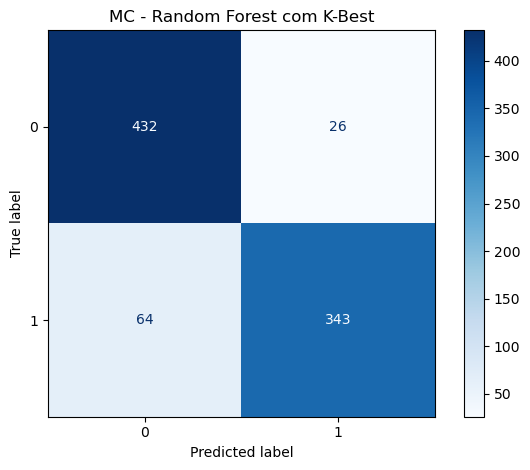


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       458
           1       0.93      0.84      0.88       407

    accuracy                           0.90       865
   macro avg       0.90      0.89      0.89       865
weighted avg       0.90      0.90      0.90       865



In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Matriz de confusão
cm = confusion_matrix(y, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('MC - Random Forest com K-Best')
plt.grid(False)
plt.tight_layout()
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y, y_pred_all))


# ROC - Modelos Simples

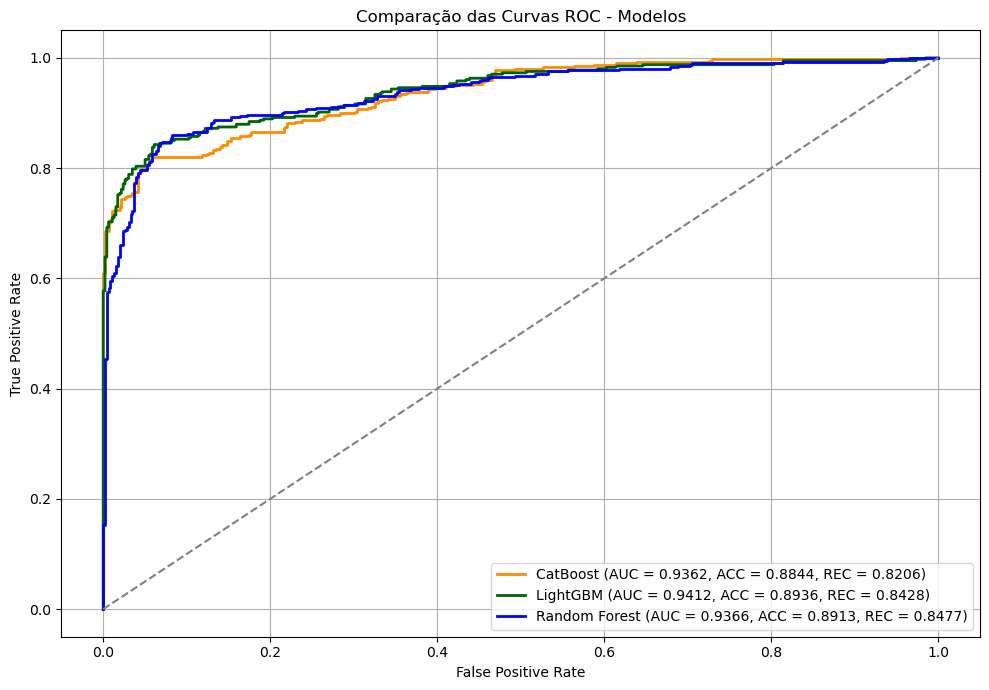

In [98]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold, cross_val_predict
# from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
# from sklearn.preprocessing import LabelEncoder
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier


# nao_categoricas = [
#     'NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#     'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT'
# ]

# # Inicializar dados para plot 
# resultados = {}

# # ========================== MODELO 1: CATBOOST ==========================
# X = df.drop(columns=['ATRASOU_FORM']).copy()
# y = df['ATRASOU_FORM'].copy()

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
# categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# for col in categorical_column_names:
#     X[col] = X[col].astype(str)

# model_cat = CatBoostClassifier(
#     iterations=50, depth=8, learning_rate=0.001, eval_metric='Accuracy',
#     verbose=0, cat_features=categorical_features_idx, random_state=42
# )

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# y_proba_cat = cross_val_predict(model_cat, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
# y_pred_cat = cross_val_predict(model_cat, X, y, cv=cv, method='predict', n_jobs=-1)

# fpr_cat, tpr_cat, _ = roc_curve(y, y_proba_cat)
# roc_auc_cat = auc(fpr_cat, tpr_cat)
# acc_cat = accuracy_score(y, y_pred_cat)
# recall_cat = recall_score(y, y_pred_cat)
# resultados['CatBoost'] = (fpr_cat, tpr_cat, roc_auc_cat, acc_cat, recall_cat)

# # ========================== MODELO 2: LIGHTGBM ==========================
# X = df.drop(columns=['ATRASOU_FORM']).copy()
# y = df['ATRASOU_FORM'].copy()

# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']

# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
# categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]

# # Converter colunas categóricas para string
# for col in categorical_column_names:
#     X[col] = X[col].astype('category')

# model_lgbm = LGBMClassifier(
#     n_estimators=200, max_depth=10, learning_rate=0.01,
#     objective='binary', random_state=42, verbose=-1
# )

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# y_proba_lgbm = cross_val_predict(model_lgbm, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
# y_pred_lgbm = cross_val_predict(model_lgbm, X, y, cv=cv, method='predict', n_jobs=-1)

# fpr_lgbm, tpr_lgbm, _ = roc_curve(y, y_proba_lgbm)
# roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
# acc_lgbm = accuracy_score(y, y_pred_lgbm)
# recall_lgbm = recall_score(y, y_pred_lgbm)
# resultados['LightGBM'] = (fpr_lgbm, tpr_lgbm, roc_auc_lgbm, acc_lgbm, recall_lgbm)

# # ========================== MODELO 3: RANDOM FOREST ==========================
# X = df.drop(columns=['ATRASOU_FORM']).copy()
# y = df['ATRASOU_FORM'].copy()

# for col in X.select_dtypes(include='object').columns:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col].astype(str))

# model_rf = RandomForestClassifier(
#     n_estimators=500, max_depth=10, min_samples_split=10, min_samples_leaf=2,
#     max_features='sqrt', bootstrap=True, random_state=42, n_jobs=-1
# )

# y_proba_rf = cross_val_predict(model_rf, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
# y_pred_rf = cross_val_predict(model_rf, X, y, cv=cv, method='predict', n_jobs=-1)

# fpr_rf, tpr_rf, _ = roc_curve(y, y_proba_rf)
# roc_auc_rf = auc(fpr_rf, tpr_rf)
# acc_rf = accuracy_score(y, y_pred_rf)
# recall_rf = recall_score(y, y_pred_rf)
# resultados['Random Forest'] = (fpr_rf, tpr_rf, roc_auc_rf, acc_rf, recall_rf)

# # ========================== PLOT ÚNICO DAS CURVAS ROC ==========================
# plt.figure(figsize=(10, 7))
# cores = {
#     'CatBoost': 'darkorange',
#     'LightGBM': 'darkgreen',
#     'Random Forest': 'blue'
# }

# for modelo, (fpr, tpr, roc_auc, acc, recall) in resultados.items():
#     plt.plot(fpr, tpr,
#              label=f'{modelo} (AUC = {roc_auc:.4f}, ACC = {acc:.4f}, REC = {recall:.4f})',
#              lw=2, color=cores[modelo])

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Comparação das Curvas ROC - Modelos')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# ROC - Modelos com K-Best

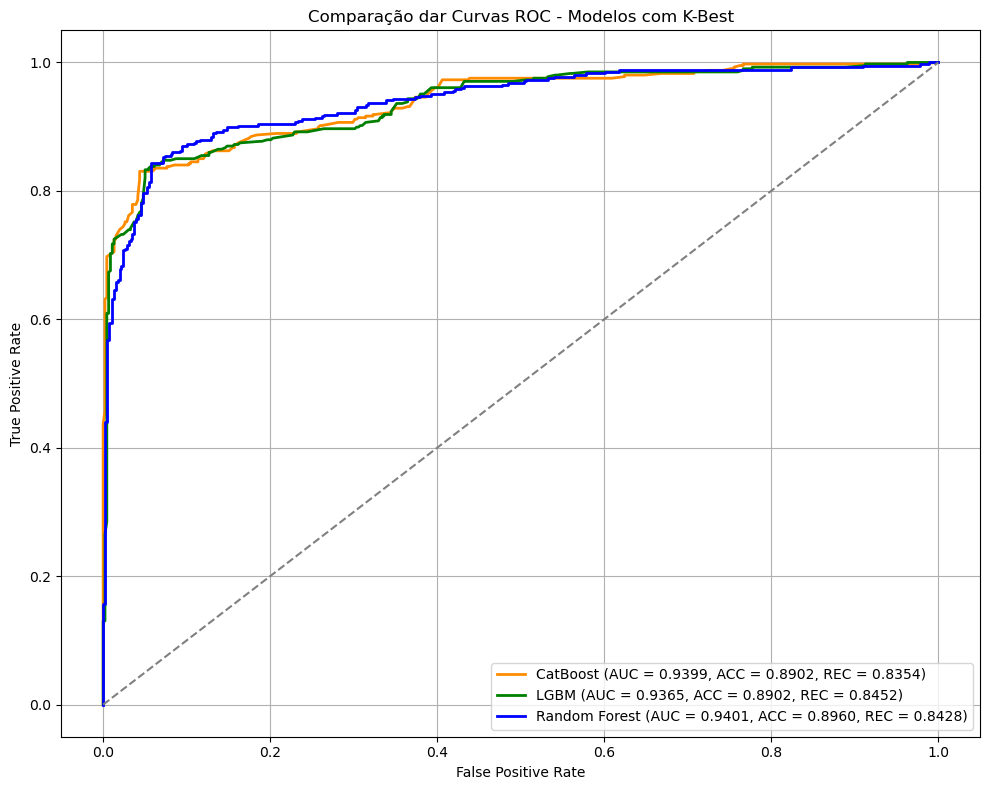

In [100]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score
# from sklearn.model_selection import StratifiedKFold, cross_val_predict
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
# from sklearn.feature_selection import SelectKBest, chi2
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier

# # Separação entre X e y
# X = df.drop(columns=['ATRASOU_FORM'])
# y = df['ATRASOU_FORM']

# # Colunas categóricas e numéricas
# nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
#                    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
# categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# # Pré-processador
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
#         ('num', MinMaxScaler(), nao_categoricas)
#     ]
# )

# # Configuração da validação cruzada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Dicionário com modelos
# modelos = {
#     "CatBoost": Pipeline(steps=[
#         ('preprocessing', preprocessor),
#         ('selectkbest', SelectKBest(score_func=chi2, k=10)),
#         ('clf', CatBoostClassifier(
#             n_estimators=100,
#             depth=10,
#             learning_rate=0.1,
#             random_state=42,
#             verbose=0
#         ))
#     ]),
#     "LGBM": Pipeline(steps=[
#         ('preprocessing', preprocessor),
#         ('selectkbest', SelectKBest(score_func=chi2, k=10)),
#         ('clf', LGBMClassifier(
#             n_estimators=200,
#             max_depth=4,
#             learning_rate=0.1,
#             random_state=42,
#             verbose=-1
#         ))
#     ]),
#     "Random Forest": Pipeline(steps=[
#         ('preprocessing', preprocessor),
#         ('selectkbest', SelectKBest(score_func=chi2, k=30)),
#         ('clf', RandomForestClassifier(
#             n_estimators=300,
#             max_depth=10,
#             min_samples_split=10,
#             min_samples_leaf=4,
#             max_features='sqrt',
#             bootstrap=True,
#             random_state=42
#         ))
#     ])
# }

# # Cores para cada modelo
# cores = {
#     "CatBoost": "darkorange",
#     "LGBM": "green",
#     "Random Forest": "blue"
# }

# # Plotagem
# plt.figure(figsize=(10, 8))

# for nome, modelo in modelos.items():
#     y_proba = cross_val_predict(modelo, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
#     y_pred = (y_proba >= 0.5).astype(int)
#     fpr, tpr, _ = roc_curve(y, y_proba)
#     roc_auc = auc(fpr, tpr)
#     acc = accuracy_score(y, y_pred)
#     recall = recall_score(y, y_pred)
#     plt.plot(fpr, tpr, lw=2, color=cores[nome], label=f'{nome} (AUC = {roc_auc:.4f}, ACC = {acc:.4f}, REC = {recall:.4f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Comparação dar Curvas ROC - Modelos com K-Best')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



========== PROCESSANDO MODELO: CatBoost ==========
  Fold 1: ACC = 0.8671, REC = 0.8642, AUC = 0.9482
  Fold 2: ACC = 0.8728, REC = 0.7407, AUC = 0.9285
  Fold 3: ACC = 0.9075, REC = 0.8395, AUC = 0.9483
  Fold 4: ACC = 0.8844, REC = 0.8049, AUC = 0.9400
  Fold 5: ACC = 0.8902, REC = 0.8537, AUC = 0.9358

  Resumo para CatBoost:
  Média Acurácia: 0.8844 (± 0.0142)
  Média Recall:   0.8206 (± 0.0447)
  Média ROC AUC:  0.9402 (± 0.0076)

========== PROCESSANDO MODELO: LightGBM ==========
  Fold 1: ACC = 0.8844, REC = 0.8519, AUC = 0.9415
  Fold 2: ACC = 0.8902, REC = 0.8148, AUC = 0.9147
  Fold 3: ACC = 0.9306, REC = 0.8889, AUC = 0.9647
  Fold 4: ACC = 0.8786, REC = 0.8171, AUC = 0.9523
  Fold 5: ACC = 0.8844, REC = 0.8415, AUC = 0.9386

  Resumo para LightGBM:
  Média Acurácia: 0.8936 (± 0.0189)
  Média Recall:   0.8428 (± 0.0270)
  Média ROC AUC:  0.9424 (± 0.0166)

========== PROCESSANDO MODELO: Random Forest ==========
  Fold 1: ACC = 0.8671, REC = 0.8395, AUC = 0.9426
  Fold 2: AC

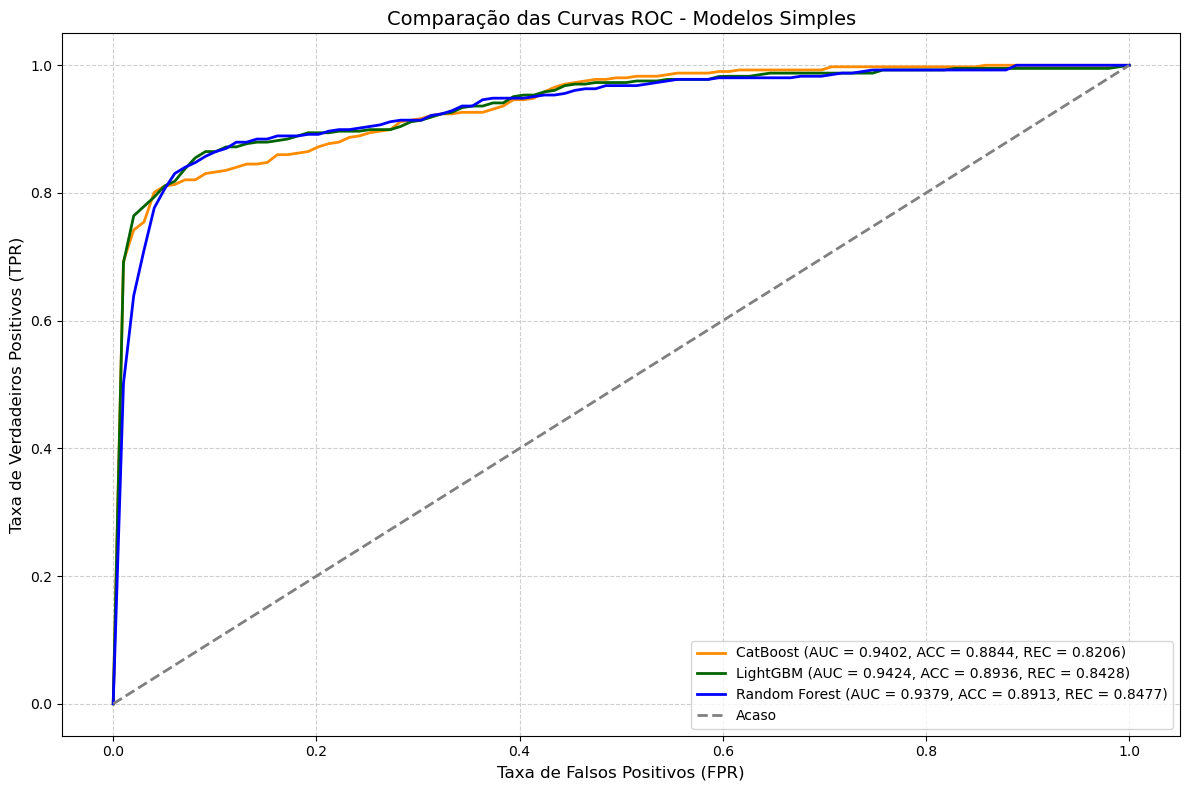

In [79]:
# Modelos sem k-best - Validação Cruzada
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Assumindo que seu DataFrame 'df' já foi carregado ---

# ========================== PREPARAÇÃO INICIAL ==========================
# Variáveis contínuas
nao_categoricas = [
    'NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
    'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT'
]

# Separar X e y uma única vez
X_orig = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário de modelos para iterar
modelos = {
    "CatBoost": CatBoostClassifier(
        iterations=50, depth=8, learning_rate=0.001, eval_metric='Accuracy',
        verbose=0, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200, max_depth=10, learning_rate=0.01,
        objective='binary', random_state=42, verbose=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=10, min_samples_leaf=2,
        max_features='sqrt', bootstrap=True, random_state=42, n_jobs=-1
    )
}

# Cores para o gráfico
cores = {
    "CatBoost": "darkorange",
    "LightGBM": "darkgreen",
    "Random Forest": "blue"
}

# Inicializar o gráfico
plt.figure(figsize=(12, 8))

# ========================== LOOP DE AVALIAÇÃO E PLOTAGEM ==========================
# Loop principal para iterar sobre cada modelo
for nome, modelo in modelos.items():
    print(f"\n========== PROCESSANDO MODELO: {nome} ==========")

    # --- Pré-processamento específico para cada modelo ---
    X = X_orig.copy()
    if nome == 'CatBoost':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]
        for col in categorical_column_names:
            X[col] = X[col].astype(str)
        fit_params = {'cat_features': categorical_features_idx}
    elif nome == 'LightGBM':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        for col in categorical_column_names:
            X[col] = X[col].astype('category')
        fit_params = {}
    elif nome == 'Random Forest':
        for col in X.columns:
            if X[col].dtype.name == 'object' or X[col].dtype.name == 'category':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])
        fit_params = {}

    # Listas para armazenar os resultados dos folds
    tprs, aucs, accs, recalls = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)

    # Loop da validação cruzada
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        modelo.fit(X_train, y_train, **fit_params)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        
        # Calcular e armazenar métricas
        fold_acc = accuracy_score(y_test, y_pred)
        fold_recall = recall_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fold_auc = auc(fpr, tpr)
        
        accs.append(fold_acc)
        recalls.append(fold_recall)
        aucs.append(fold_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        # =========================================================================
        # ADICIONADO DE VOLTA: Exibição dos resultados para cada fold
        # =========================================================================
        print(f"  Fold {i+1}: ACC = {fold_acc:.4f}, REC = {fold_recall:.4f}, AUC = {fold_auc:.4f}")

    
    # Calcular médias e desvios padrão
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc, std_auc = np.mean(aucs), np.std(aucs)
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    mean_recall, std_recall = np.mean(recalls), np.std(recalls)

    # =========================================================================
    # ADICIONADO DE VOLTA: Resumo com média e desvio padrão no console
    # =========================================================================
    print(f"\n  Resumo para {nome}:")
    print(f"  Média Acurácia: {mean_acc:.4f} (± {std_acc:.4f})")
    print(f"  Média Recall:   {mean_recall:.4f} (± {std_recall:.4f})")
    print(f"  Média ROC AUC:  {mean_auc:.4f} (± {std_auc:.4f})")

    # --- Plotagem para o modelo atual ---
    legenda = (f'{nome} (AUC = {mean_auc:.4f}, ACC = {mean_acc:.4f}, REC = {mean_recall:.4f})')
    plt.plot(mean_fpr, mean_tpr, color=cores[nome], lw=2, label=legenda)

# ========================== FINALIZAÇÃO DO GRÁFICO ==========================
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Acaso')
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Comparação das Curvas ROC - Modelos Simples', fontsize=14)
plt.legend(loc='lower right', fontsize='medium')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


========== GERANDO MATRIZ DE CONFUSÃO PARA: CatBoost ==========

========== GERANDO MATRIZ DE CONFUSÃO PARA: LightGBM ==========

========== GERANDO MATRIZ DE CONFUSÃO PARA: Random Forest ==========


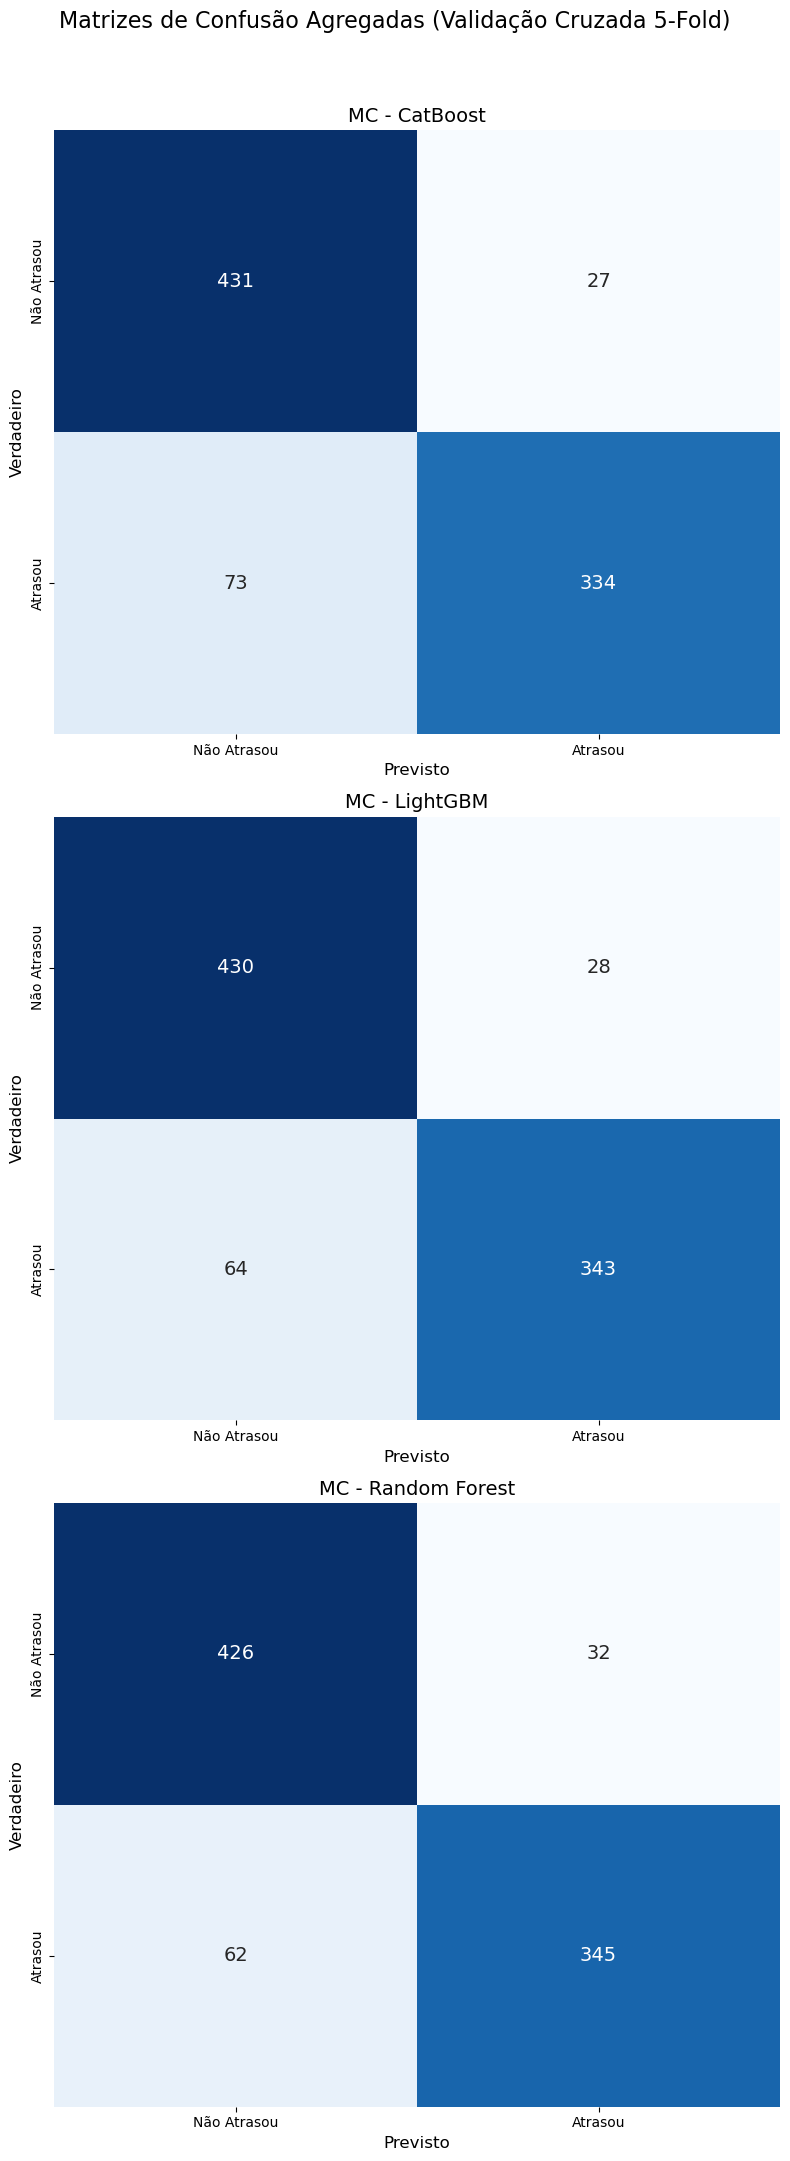

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Dicionário para armazenar as matrizes de confusão agregadas ---
matrizes_confusao = {
    "CatBoost": np.zeros((2, 2), dtype=int),
    "LightGBM": np.zeros((2, 2), dtype=int),
    "Random Forest": np.zeros((2, 2), dtype=int)
}

# ========================== LOOP DE CÁLCULO DA MATRIZ DE CONFUSÃO ==========================
# Loop principal para iterar sobre cada modelo
for nome, modelo in modelos.items():
    print(f"\n========== GERANDO MATRIZ DE CONFUSÃO PARA: {nome} ==========")

    # --- Pré-processamento específico para cada modelo (igual ao anterior) ---
    X = X_orig.copy()
    if nome == 'CatBoost':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        categorical_features_idx = [X.columns.get_loc(col) for col in categorical_column_names]
        for col in categorical_column_names:
            X[col] = X[col].astype(str)
        fit_params = {'cat_features': categorical_features_idx}
    elif nome == 'LightGBM':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        for col in categorical_column_names:
            X[col] = X[col].astype('category')
        fit_params = {}
    elif nome == 'Random Forest':
        for col in X.columns:
            if X[col].dtype.name == 'object' or X[col].dtype.name == 'category':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])
        fit_params = {}

    # Loop da validação cruzada para acumular a matriz de confusão
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treina o modelo e faz as previsões
        modelo.fit(X_train, y_train, **fit_params)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        
        # Calcula a matriz de confusão para o fold atual
        cm_fold = confusion_matrix(y_test, y_pred)
        
        # Adiciona (soma) à matriz de confusão agregada do modelo
        matrizes_confusao[nome] += cm_fold

# ========================== PLOTAGEM DAS MATRIZES DE CONFUSÃO ==========================

# Cria a figura com 3 subplots (um para cada modelo)
fig, axes = plt.subplots(3, 1, figsize=(8, 22))

# Título geral para a figura
fig.suptitle('Matrizes de Confusão Agregadas (Validação Cruzada 5-Fold)', fontsize=16)

# Itera sobre os modelos e suas matrizes de confusão para plotar
for ax, (nome, cm) in zip(axes, matrizes_confusao.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                annot_kws={"size": 14}) # Aumenta o tamanho da fonte da anotação
    ax.set_title(f'MC - {nome}', fontsize=14)
    ax.set_xlabel('Previsto', fontsize=12)
    ax.set_ylabel('Verdadeiro', fontsize=12)
    ax.set_xticklabels(['Não Atrasou', 'Atrasou'])
    ax.set_yticklabels(['Não Atrasou', 'Atrasou'], va='center')

# Ajusta o layout para evitar sobreposição e exibe o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o retângulo para caber o suptitle
plt.show()

Iniciando análise de importância das variáveis...
--> Processando modelo: CatBoost
--> Processando modelo: LightGBM
--> Processando modelo: Random Forest
Análise finalizada. Gerando gráficos...


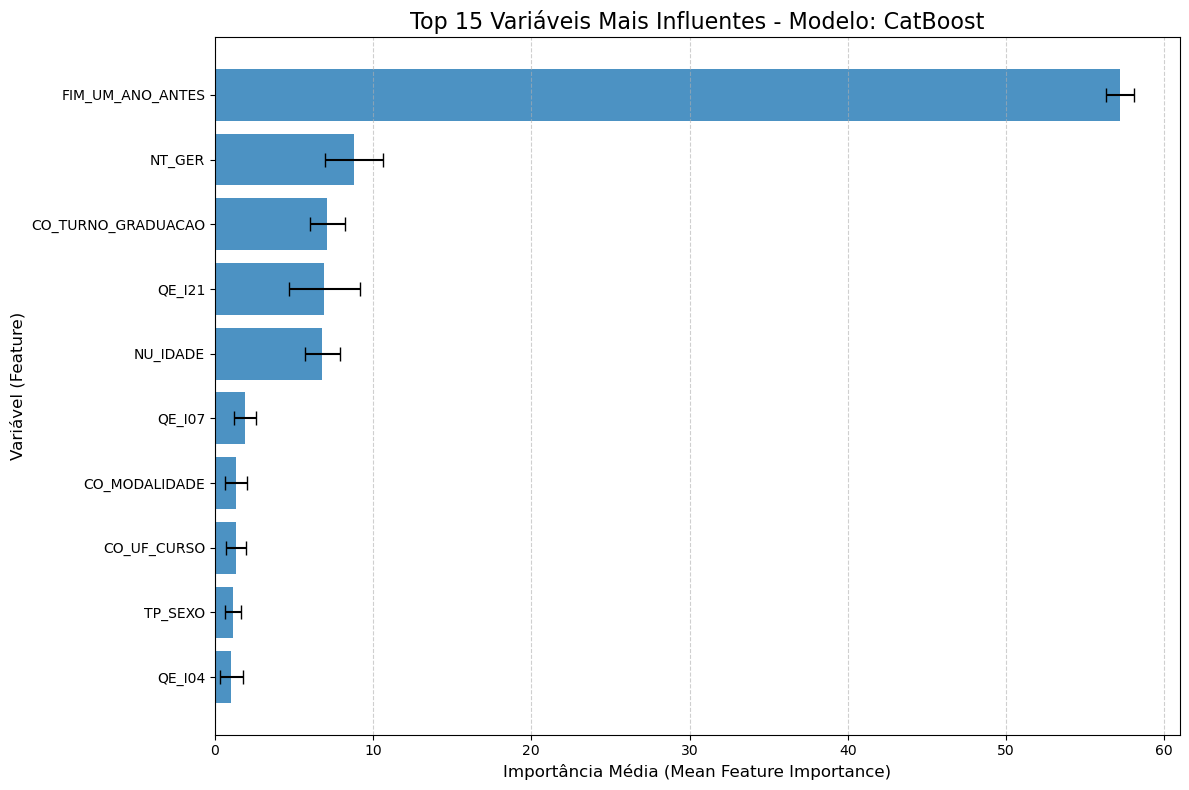

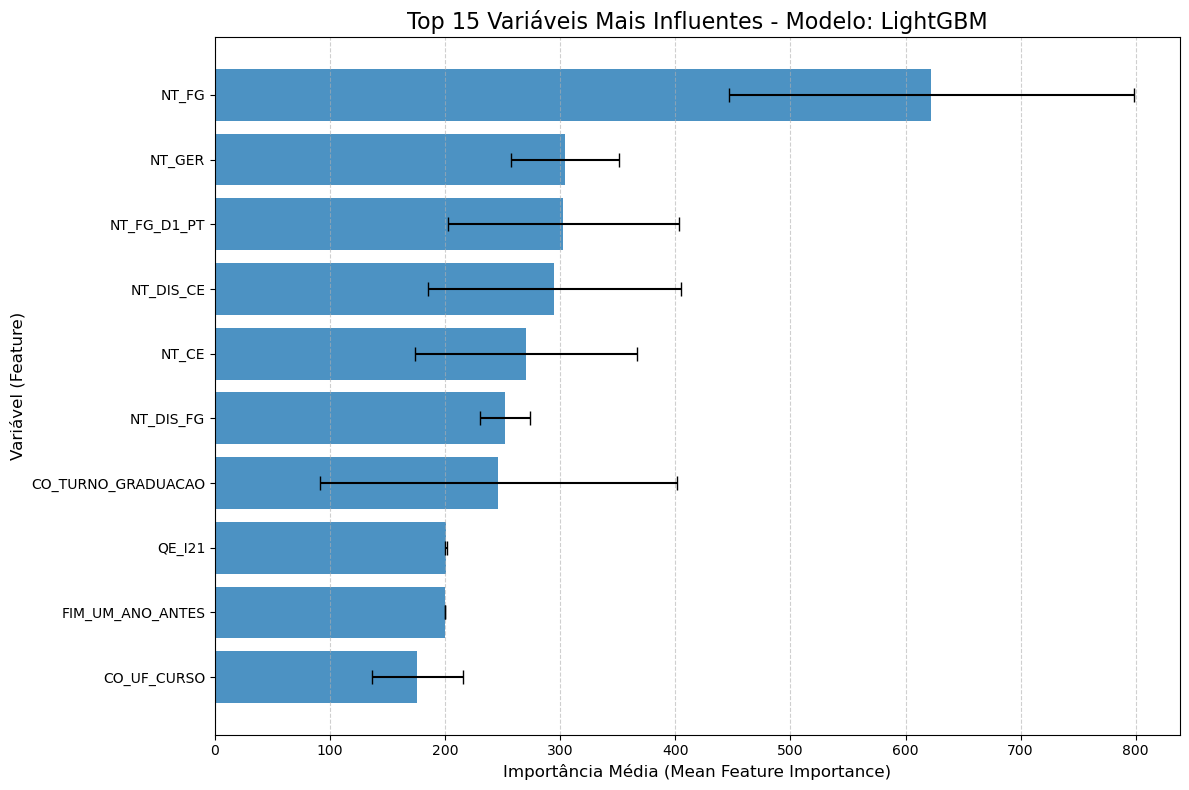

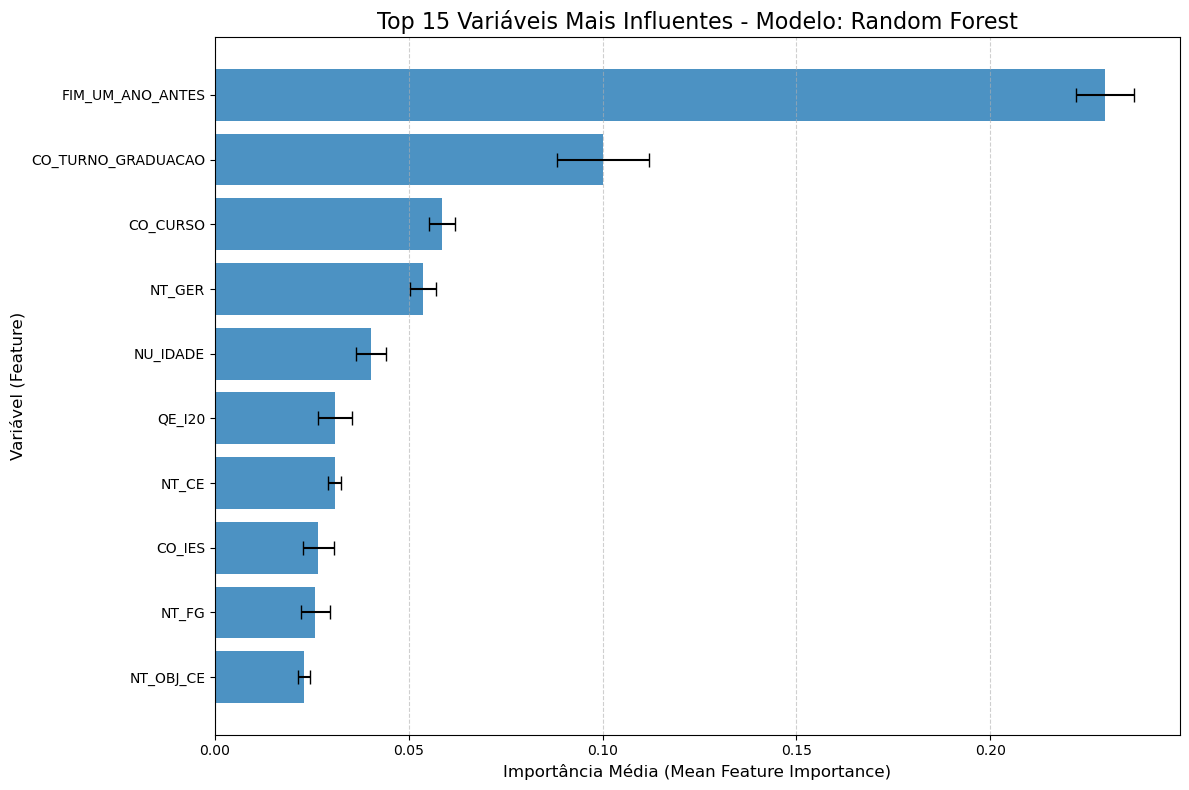

In [85]:
# ===================================================================
# ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS (FEATURE IMPORTANCE)
# ===================================================================

# Dicionário para armazenar as importâncias de cada modelo
importances_dict = {}

print("Iniciando análise de importância das variáveis...")

# Loop principal para iterar sobre cada modelo
for nome, modelo in modelos.items():
    print(f"--> Processando modelo: {nome}")

    # Lista para armazenar as importâncias de cada fold para o modelo atual
    fold_importances = []
    
    # --- Pré-processamento (necessário para ter o 'X' correto para cada modelo) ---
    # Este bloco é repetido para garantir que o 'X' e os nomes das colunas estejam corretos
    X = X_orig.copy() 
    if nome == 'CatBoost':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        for col in categorical_column_names:
            X[col] = X[col].astype(str)
        fit_params = {'cat_features': [X.columns.get_loc(col) for col in categorical_column_names]}
    elif nome == 'LightGBM':
        categorical_column_names = [col for col in X.columns if col not in nao_categoricas]
        for col in categorical_column_names:
            X[col] = X[col].astype('category')
        fit_params = {}
    elif nome == 'Random Forest':
        for col in X.columns:
            if X[col].dtype.name == 'object' or X[col].dtype.name == 'category':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col])
        fit_params = {}

    # Loop da validação cruzada para extrair as importâncias
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treina o modelo
        modelo.fit(X_train, y_train, **fit_params)
        
        # Extrai e armazena a importância das features do modelo treinado neste fold
        fold_importances.append(modelo.feature_importances_)
        
    # Agrega os resultados dos folds
    # Calcula a média e o desvio padrão da importância de cada feature
    mean_importances = np.mean(fold_importances, axis=0)
    std_importances = np.std(fold_importances, axis=0)
    
    # Armazena os resultados no dicionário
    importances_dict[nome] = {
        'mean': mean_importances,
        'std': std_importances,
        'features': X.columns # Nomes das features
    }

print("Análise finalizada. Gerando gráficos...")

# ========================== PLOTAGEM DOS GRÁFICOS DE IMPORTÂNCIA ==========================

# Itera sobre os resultados armazenados para plotar um gráfico por modelo
for nome, data in importances_dict.items():
    # Cria um DataFrame do pandas para facilitar a ordenação e plotagem
    df_importance = pd.DataFrame({
        'feature': data['features'],
        'importance': data['mean'],
        'std': data['std']
    })
    
    # Ordena o DataFrame pela importância média
    df_importance = df_importance.sort_values('importance', ascending=False)
    
    # Seleciona as Top 15 features para manter o gráfico legível
    df_top15 = df_importance.head(10)
    
    # Cria a figura para o gráfico
    plt.figure(figsize=(12, 8))
    
    # Plota o gráfico de barras horizontais
    plt.barh(
        df_top15['feature'],
        df_top15['importance'],
        xerr=df_top15['std'], # Adiciona as barras de erro (desvio padrão)
        align='center',
        alpha=0.8,
        capsize=5 # Tamanho do "chapéu" da barra de erro
    )
    
    # Inverte o eixo Y para que a feature mais importante fique no topo
    plt.gca().invert_yaxis()
    
    # Adiciona títulos e rótulos
    plt.title(f'Top 15 Variáveis Mais Influentes - Modelo: {nome}', fontsize=16)
    plt.xlabel('Importância Média (Mean Feature Importance)', fontsize=12)
    plt.ylabel('Variável (Feature)', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Mostra o gráfico
    plt.show()


========== PROCESSANDO MODELO: CatBoost (com K-Best) ==========
  Fold 1: ACC = 0.8613, REC = 0.8395, AUC = 0.9312
  Fold 2: ACC = 0.8844, REC = 0.7778, AUC = 0.9257
  Fold 3: ACC = 0.9249, REC = 0.8889, AUC = 0.9645
  Fold 4: ACC = 0.8844, REC = 0.8171, AUC = 0.9420
  Fold 5: ACC = 0.8960, REC = 0.8537, AUC = 0.9440

  Resumo para CatBoost:
  Média Acurácia: 0.8902 (± 0.0207)
  Média Recall:   0.8354 (± 0.0371)
  Média ROC AUC:  0.9415 (± 0.0134)

========== PROCESSANDO MODELO: LGBM (com K-Best) ==========
  Fold 1: ACC = 0.8555, REC = 0.8395, AUC = 0.9271
  Fold 2: ACC = 0.8786, REC = 0.7901, AUC = 0.9119
  Fold 3: ACC = 0.9249, REC = 0.9012, AUC = 0.9626
  Fold 4: ACC = 0.8960, REC = 0.8415, AUC = 0.9469
  Fold 5: ACC = 0.8960, REC = 0.8537, AUC = 0.9430

  Resumo para LGBM:
  Média Acurácia: 0.8902 (± 0.0228)
  Média Recall:   0.8452 (± 0.0355)
  Média ROC AUC:  0.9383 (± 0.0174)

========== PROCESSANDO MODELO: Random Forest (com K-Best) ==========
  Fold 1: ACC = 0.8728, REC = 0.

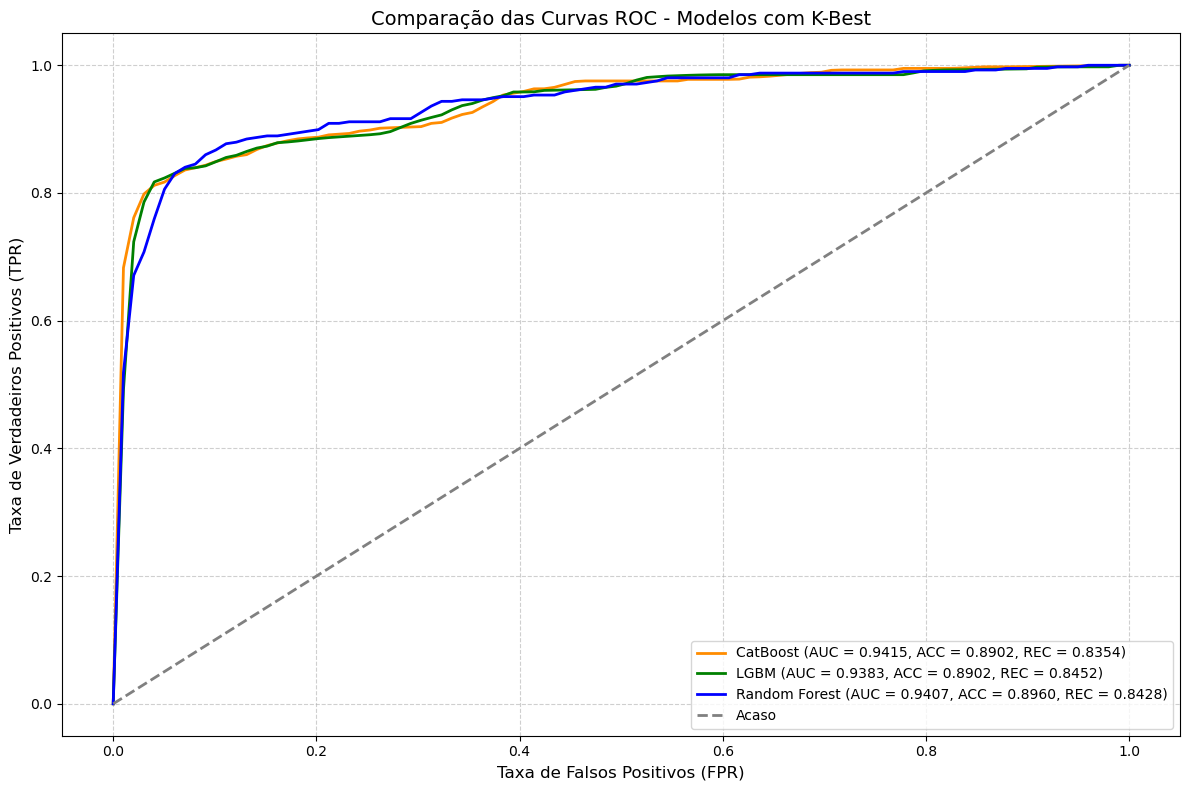

In [99]:
# ===================================================================
# PARTE 1: PREPARAÇÃO E DEFINIÇÃO DOS MODELOS (Seu código, sem alterações)
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Assumindo que seu DataFrame 'df' já foi carregado ---

# Separação entre X e y
X = df.drop(columns=['ATRASOU_FORM'])
y = df['ATRASOU_FORM']

# Colunas categóricas e numéricas
nao_categoricas = ['NT_GER', 'NT_FG', 'NT_OBJ_FG', 'NT_DIS_FG', 'NT_FG_D1', 'NT_FG_D1_CT',
                   'NT_CE', 'NT_OBJ_CE', 'NT_DIS_CE', 'NT_CE_D1', 'NU_IDADE', 'NT_FG_D1_PT']
categorical_column_names = [col for col in X.columns if col not in nao_categoricas]

# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_column_names),
        ('num', MinMaxScaler(), nao_categoricas)
    ]
)

# Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definição dos modelos com Pipeline
modelos = {
    "CatBoost": Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('selectkbest', SelectKBest(score_func=chi2, k=10)),
        ('clf', CatBoostClassifier(
            n_estimators=100,
            depth=10,
            learning_rate=0.1,
            random_state=42,
            verbose=0
        ))
    ]),
    "LGBM": Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('selectkbest', SelectKBest(score_func=chi2, k=10)),
        ('clf', LGBMClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1,
            random_state=42,
            verbose=-1
        ))
    ]),
    "Random Forest": Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('selectkbest', SelectKBest(score_func=chi2, k=30)),
        ('clf', RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            bootstrap=True,
            random_state=42
        ))
    ])
}

# Cores para cada modelo
cores = {
    "CatBoost": "darkorange",
    "LGBM": "green",
    "Random Forest": "blue"
}


# ===================================================================
# PARTE 2: AVALIAÇÃO E PLOTAGEM (Lógica de saída ajustada)
# ===================================================================

# Inicia a figura para os plots
plt.figure(figsize=(12, 8))

# Loop principal para iterar sobre cada modelo
for nome, modelo in modelos.items():
    print(f"\n========== PROCESSANDO MODELO: {nome} (com K-Best) ==========")
    
    # Listas para armazenar os resultados dos folds
    tprs, aucs, accs, recalls = [], [], [], []
    mean_fpr = np.linspace(0, 1, 100)

    # Loop da validação cruzada
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treina o pipeline completo (pré-processamento + seleção + classificador)
        # O CatBoost pode gerar um UserWarning sobre features não usadas após o SelectKBest, é esperado.
        modelo.fit(X_train, y_train) 
        
        y_proba = modelo.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        
        # Calcular e armazenar métricas
        fold_acc = accuracy_score(y_test, y_pred)
        fold_recall = recall_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fold_auc = auc(fpr, tpr)
        
        accs.append(fold_acc)
        recalls.append(fold_recall)
        aucs.append(fold_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        # Exibe os resultados para cada fold
        print(f"  Fold {i+1}: ACC = {fold_acc:.4f}, REC = {fold_recall:.4f}, AUC = {fold_auc:.4f}")

    # Calcular médias e desvios padrão
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc, std_auc = np.mean(aucs), np.std(aucs)
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    mean_recall, std_recall = np.mean(recalls), np.std(recalls)

    # Exibe o resumo com média e desvio padrão no console
    print(f"\n  Resumo para {nome}:")
    print(f"  Média Acurácia: {mean_acc:.4f} (± {std_acc:.4f})")
    print(f"  Média Recall:   {mean_recall:.4f} (± {std_recall:.4f})")
    print(f"  Média ROC AUC:  {mean_auc:.4f} (± {std_auc:.4f})")

    # --- Plotagem para o modelo atual ---
    legenda = (f'{nome} (AUC = {mean_auc:.4f}, ACC = {mean_acc:.4f}, REC = {mean_recall:.4f})')
    plt.plot(mean_fpr, mean_tpr, color=cores.get(nome, 'black'), lw=2, label=legenda)

# ========================== FINALIZAÇÃO DO GRÁFICO ==========================
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Acaso')
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Comparação das Curvas ROC - Modelos com K-Best', fontsize=14)
plt.legend(loc='lower right', fontsize='medium')
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

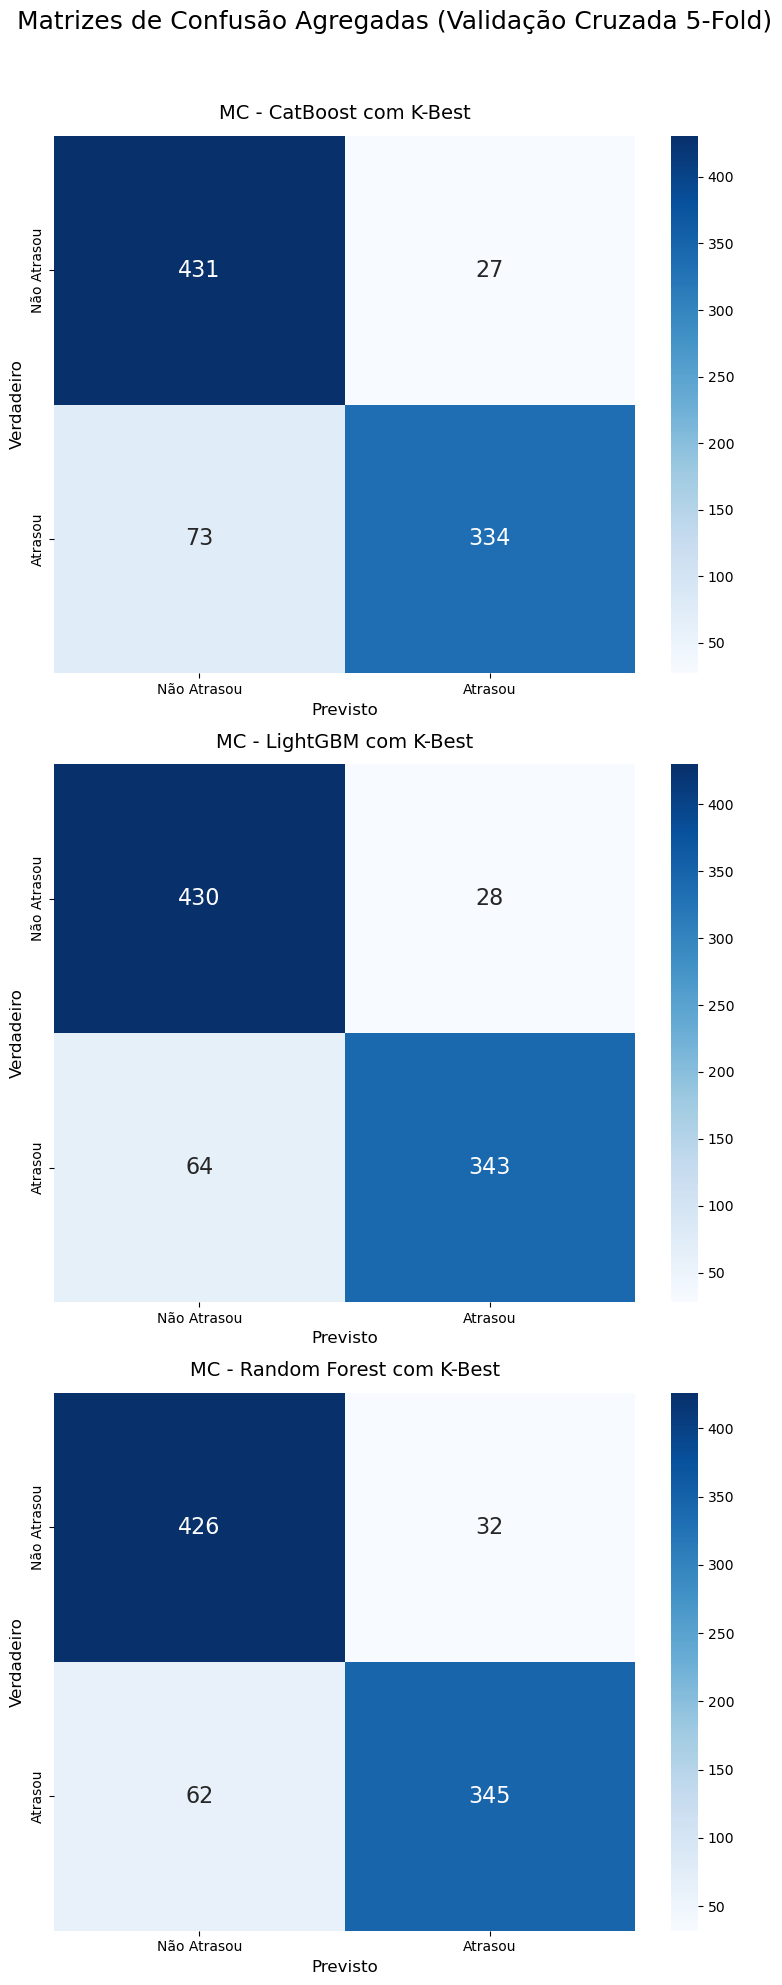

In [89]:
# ========================== PLOTAGEM DAS MATRIZES DE CONFUSÃO (APENAS NÚMEROS) ==========================

# Cria a figura com 3 subplots (3 linhas, 1 coluna)
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

# Título geral para a figura
fig.suptitle('Matrizes de Confusão Agregadas (Validação Cruzada 5-Fold)', fontsize=18, y=0.99)

# Itera sobre os modelos e suas matrizes para plotar
for ax, (nome, cm) in zip(axes.flatten(), matrizes_confusao.items()):
    
    # --- ALTERAÇÃO AQUI ---
    # Removemos toda a criação de 'labels' e usamos as opções padrão do seaborn
    # annot=True: Habilita a anotação dos números em cada célula.
    # fmt='d': Formata os números como inteiros decimais.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True,
                annot_kws={"size": 16}) # Aumentamos o tamanho da fonte para melhor leitura
    
    ax.set_title(f'MC - {nome} com K-Best', fontsize=14, pad=12)
    ax.set_xlabel('Previsto', fontsize=12)
    ax.set_ylabel('Verdadeiro', fontsize=12)
    ax.set_xticklabels(['Não Atrasou', 'Atrasou'])
    ax.set_yticklabels(['Não Atrasou', 'Atrasou'], va='center')

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Iniciando análise de importância das variáveis nos pipelines...
--> Processando modelo: CatBoost
--> Processando modelo: LGBM
--> Processando modelo: Random Forest
Análise finalizada. Gerando gráficos...


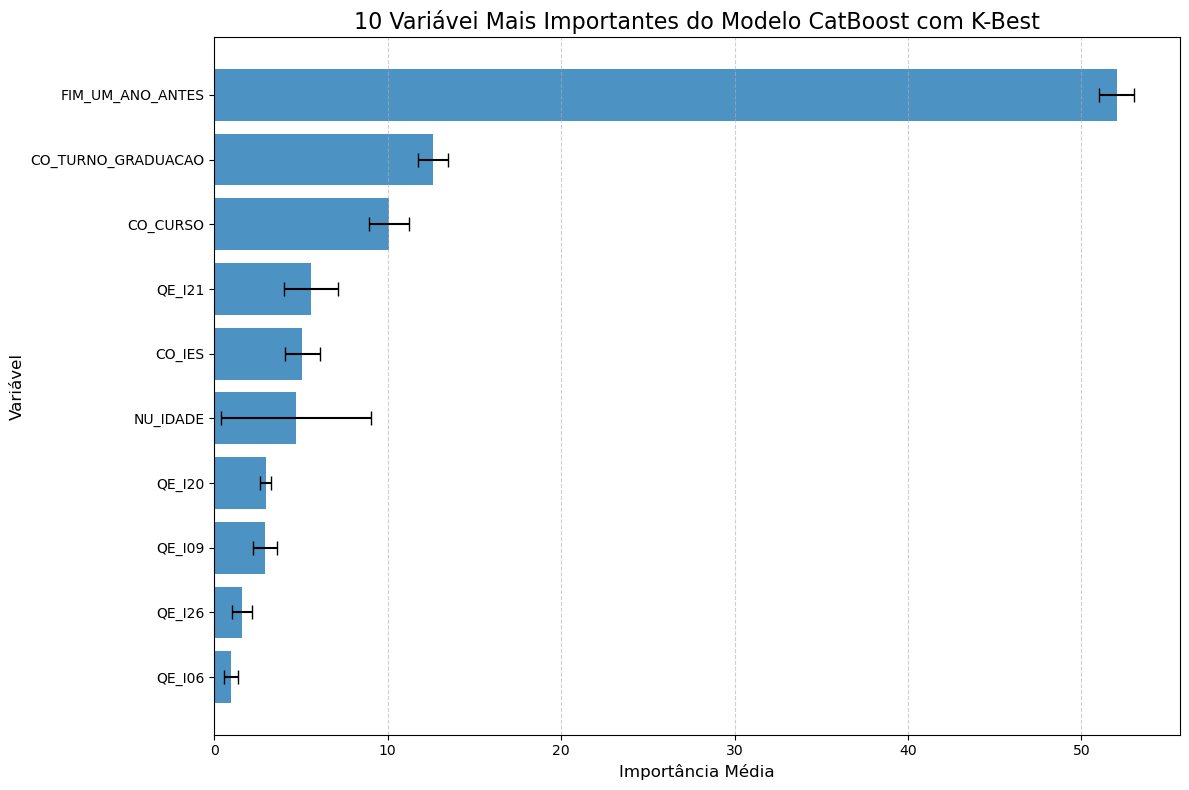

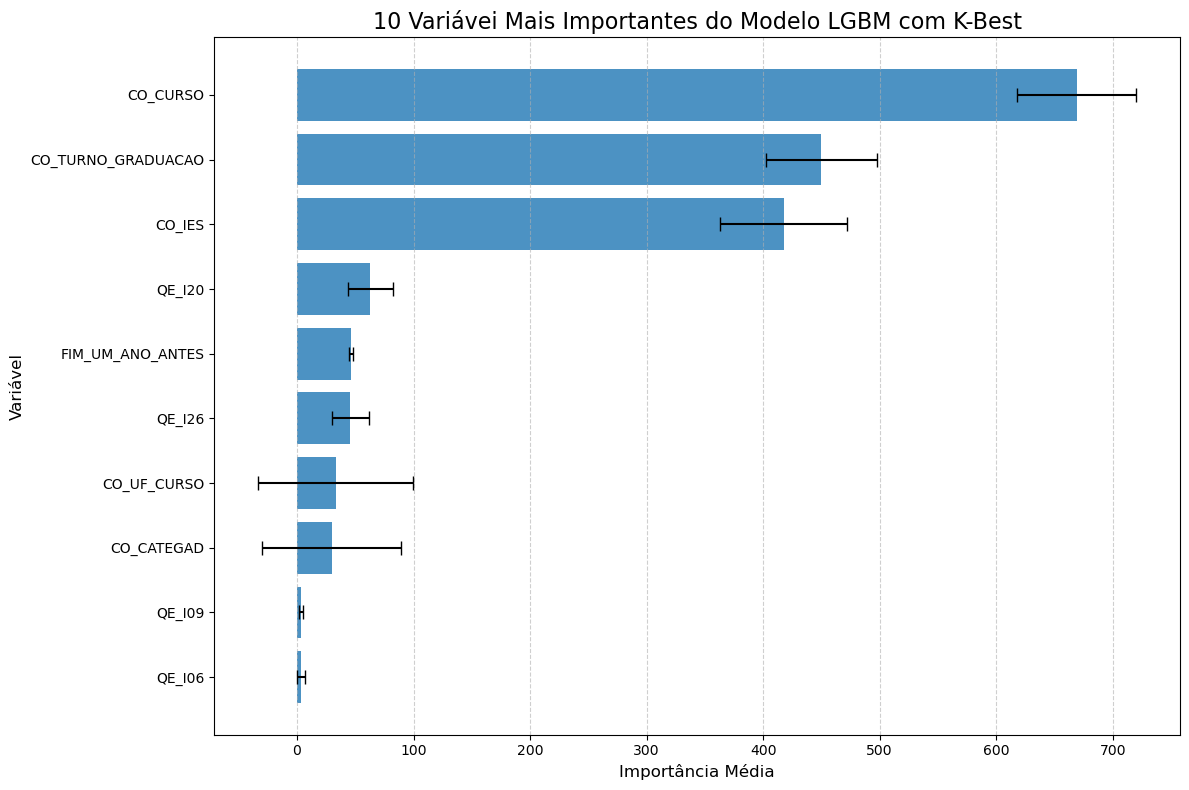

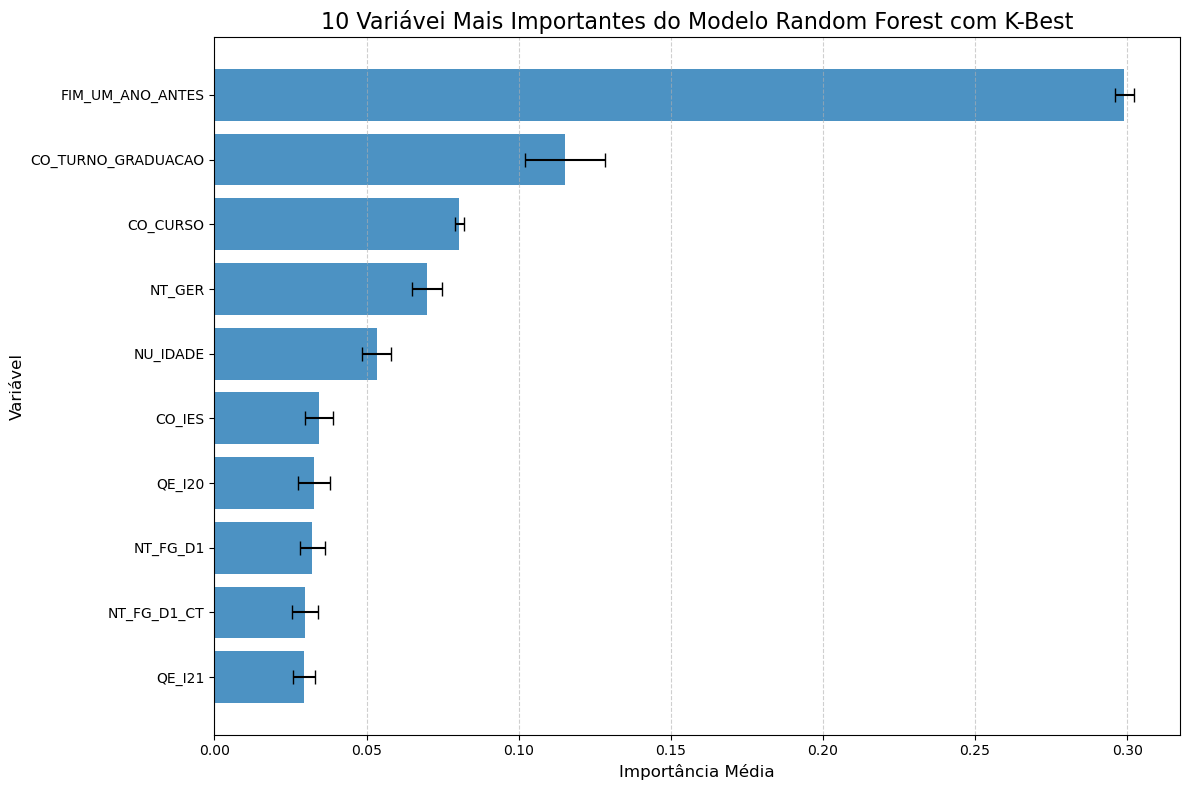

In [97]:
# ===================================================================
# ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS (PIPELINE COM K-BEST)
# ===================================================================

# Dicionário para armazenar os resultados
importances_dict = {}

# Lista com todos os nomes de features na ordem que o preprocessor as organiza
all_feature_names = categorical_column_names + nao_categoricas

print("Iniciando análise de importância das variáveis nos pipelines...")

# Loop principal para iterar sobre cada modelo
for nome, modelo_pipeline in modelos.items():
    print(f"--> Processando modelo: {nome}")

    # Dicionário para agregar as importâncias por nome da feature durante a CV
    # A chave é o nome da feature, o valor é uma lista de importâncias (uma por fold)
    feature_importance_aggregator = {name: [] for name in all_feature_names}
    
    # Loop da validação cruzada
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treina o pipeline completo
        modelo_pipeline.fit(X_train, y_train)
        
        # --- Extração das informações de dentro do Pipeline ---
        
        # 1. Acessa o seletor K-Best treinado
        selector = modelo_pipeline.named_steps['selectkbest']
        
        # 2. Acessa o classificador final treinado
        classifier = modelo_pipeline.named_steps['clf']
        
        # 3. Pega as importâncias calculadas pelo classificador final
        #    (Isso terá 'k' valores, um para cada feature selecionada)
        scores_selected_features = classifier.feature_importances_
        
        # 4. Pega os nomes das features que foram selecionadas pelo K-Best
        mask = selector.get_support() # Cria uma máscara booleana (True/False)
        selected_names = np.array(all_feature_names)[mask]
        
        # 5. Mapeia a importância para cada feature selecionada
        fold_importance_map = dict(zip(selected_names, scores_selected_features))
        
        # 6. Preenche o agregador: se a feature foi selecionada, usa seu score, senão, usa 0
        for feature_name in all_feature_names:
            importance = fold_importance_map.get(feature_name, 0)
            feature_importance_aggregator[feature_name].append(importance)

    # Calcula a média e o desvio padrão da importância de cada feature nos 5 folds
    mean_importances = {name: np.mean(scores) for name, scores in feature_importance_aggregator.items()}
    std_importances = {name: np.std(scores) for name, scores in feature_importance_aggregator.items()}
    
    # Armazena os resultados no dicionário principal
    importances_dict[nome] = {
        'mean': mean_importances,
        'std': std_importances,
    }

print("Análise finalizada. Gerando gráficos...")


# ========================== PLOTAGEM DOS GRÁFICOS DE IMPORTÂNCIA ==========================

for nome, data in importances_dict.items():
    # Cria um DataFrame do pandas a partir dos dicionários de média e desvio padrão
    df_importance = pd.DataFrame({
        'feature': list(data['mean'].keys()),
        'importance': list(data['mean'].values()),
        'std': list(data['std'].values())
    })
    
    # Ordena o DataFrame pela importância média
    df_importance = df_importance.sort_values('importance', ascending=False)
    
    # Filtra features com importância média > 0 para plotar apenas as que foram selecionadas ao menos uma vez
    df_plot = df_importance[df_importance['importance'] > 0]
    
    # Limita a 20 features para manter o gráfico legível
    df_plot = df_plot.head(10)
    
    # Cria a figura para o gráfico
    plt.figure(figsize=(12, 8))
    
    # Plota o gráfico de barras horizontais
    plt.barh(
        df_plot['feature'],
        df_plot['importance'],
        xerr=df_plot['std'],
        align='center',
        alpha=0.8,
        capsize=5
    )
    
    plt.gca().invert_yaxis()
    
    plt.title(f'10 Variávei Mais Importantes do Modelo {nome} com K-Best', fontsize=16)
    plt.xlabel('Importância Média', fontsize=12)
    plt.ylabel('Variável', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.show()

# Teste de Friedman

In [68]:
!pip install scikit-posthocs

Defaulting to user installation because normal site-packages is not writeable


In [70]:
import pandas as pd
import numpy as np
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt

# Estruturando os dados a partir dos seus resultados por fold
data = {
    'AUC': np.array([
        [0.9482, 0.9415, 0.9426, 0.9312, 0.9271, 0.9395], # Fold 1
        [0.9285, 0.9147, 0.9165, 0.9257, 0.9119, 0.9153], # Fold 2
        [0.9483, 0.9647, 0.9610, 0.9645, 0.9626, 0.9648], # Fold 3
        [0.9400, 0.9523, 0.9363, 0.9420, 0.9469, 0.9406], # Fold 4
        [0.9358, 0.9386, 0.9333, 0.9440, 0.9430, 0.9430]  # Fold 5
    ]),
    'Acurácia': np.array([
        [0.8671, 0.8844, 0.8671, 0.8613, 0.8555, 0.8728], # Fold 1
        [0.8728, 0.8902, 0.8960, 0.8844, 0.8786, 0.8960], # Fold 2
        [0.9075, 0.9306, 0.9306, 0.9249, 0.9249, 0.9306], # Fold 3
        [0.8844, 0.8786, 0.8960, 0.8844, 0.8960, 0.8960], # Fold 4
        [0.8902, 0.8844, 0.8671, 0.8960, 0.8960, 0.8844]  # Fold 5
    ]),
    'Recall': np.array([
        [0.8642, 0.8519, 0.8395, 0.8395, 0.8395, 0.8272], # Fold 1
        [0.7407, 0.8148, 0.8272, 0.7778, 0.7901, 0.8148], # Fold 2
        [0.8395, 0.8889, 0.8889, 0.8889, 0.9012, 0.8889], # Fold 3
        [0.8049, 0.8171, 0.8415, 0.8171, 0.8415, 0.8293], # Fold 4
        [0.8537, 0.8415, 0.8415, 0.8537, 0.8537, 0.8537]  # Fold 5
    ])
}

model_names = [
    'CatBoost', 'LightGBM', 'Random Forest',
    'CatBoost (K-Best)', 'LGBM (K-Best)', 'RF (K-Best)'
]

# Itera sobre cada métrica para realizar a análise completa
for metric, values in data.items():
    print(f"\n========== ANÁLISE PARA A MÉTRICA: {metric.upper()} ==========")

    # 1. Teste de Friedman
    stat, p_value = friedmanchisquare(*values.T)
    print(f"\n--- Teste de Friedman ---")
    print(f"Estatística (Chi-quadrado): {stat:.4f}")
    print(f"P-valor: {p_value:.4f}")

    # Nível de significância
    alpha = 0.05
    if p_value < alpha:
        print("Conclusão: Rejeitamos a hipótese nula. Existe uma diferença estatisticamente significativa entre os modelos.")

        # 2. Teste Post-hoc de Nemenyi
        print("\n--- Teste Post-hoc de Nemenyi (P-valores) ---")
        nemenyi_results = sp.posthoc_nemenyi_friedman(values)
        nemenyi_results.columns = model_names
        nemenyi_results.index = model_names
        print("Pares de modelos com p-valor < 0.05 têm performance significativamente diferente:")
        print(nemenyi_results.round(4))

        # 3. Diagrama de Diferença Crítica (CD)
        print("\n--- Diagrama de Diferença Crítica (CD) ---")
        sp.sign_plot(nemenyi_results, alpha=alpha)
        plt.title(f"Diagrama de Diferença Crítica (Nemenyi) para {metric}")
        plt.show()

    else:
        print("Conclusão: Não rejeitamos a hipótese nula. Não há evidência de diferença estatisticamente significativa entre os modelos.")


========== ANÁLISE PARA A MÉTRICA: AUC ==========

--- Teste de Friedman ---
Estatística (Chi-quadrado): 2.9885
P-valor: 0.7018
Conclusão: Não rejeitamos a hipótese nula. Não há evidência de diferença estatisticamente significativa entre os modelos.

========== ANÁLISE PARA A MÉTRICA: ACURÁCIA ==========

--- Teste de Friedman ---
Estatística (Chi-quadrado): 4.5963
P-valor: 0.4671
Conclusão: Não rejeitamos a hipótese nula. Não há evidência de diferença estatisticamente significativa entre os modelos.

========== ANÁLISE PARA A MÉTRICA: RECALL ==========

--- Teste de Friedman ---
Estatística (Chi-quadrado): 3.0272
P-valor: 0.6958
Conclusão: Não rejeitamos a hipótese nula. Não há evidência de diferença estatisticamente significativa entre os modelos.
